<h1 class="alert alert-block alert-info" style="text-align:center; font-size:36px">Chess Visualization Project, Part 2</h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> This is Part 2 of my two part series for visualizing chess data. In this notebook, I take polished and cleaned chess portable game notation (PGN) and perform different analyses and visualizations on the data. Whether you're a beginner and only know the rules of chess or are a seasoned master, my goal with this notebook is to visualize the data I've compiled in an easy-to-digest manner. <span style="color:blue">The cool visualizations are towards the bottom of the notebook (last two sections), so you should just skip there if you're only here for the visualizations.</span> For those who are here for the notebook's coding aspect, I have linked <a href="https://www.kaggle.com/ironicninja/converting-raw-chess-pgn-to-readable-data"> Part 1 Notebook</a> here, where I cleaned the data I gathered from <a href="https://database.lichess.org/">https://database.lichess.org/</a>.</p>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> <span style="font-weight: bold">A bit about me:</span> I was motivated to complete this project because I am fascinated by the artform and creativity involved in both computer science and chess, and wanted to synthesize two of my favorite hobbies into this visualization project. I've been coding for a little over a year now, and have played chess for over a decade (my highest USCF rating has been ~1800 though I don't play competitively anymore).</p>
    
<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> Finally, if you enjoy this notebook, please leave an <span style="font-weight: bold; color: green">upvote!</span> I would really appreciate it. </p>

<h2> Table of Contents: </h2>
<ol style="font-size:15px; font-family:verdana">
    <li> <a href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#eda"> Foundational Preprocessing </a></li>
    <li> <a href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#gamelength"> Chess Game Length:</a> distribution, variability, importance </li>
    <li> <a href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#piecemovement"> Piece Movement: </a> what chess pieces should you move first? </li>
    <li> <a href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#square"> Popular Squares:</a> what squares do individual chess pieces like to move to?</li>
</ol>


<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="imports">Reading the Raw Data / Essential Imports <a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#imports">¶</a></h1>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import math
from functools import partial
import multiprocessing
from time import sleep
import warnings

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> I utilize the datatable package to import my data, as it is much faster than the normal pandas read csv function. </p>

In [ ]:
!pip install datatable
import datatable as dt


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
import os
import datatable as dt
import gc

# List of dataset parts
files = ["lichess_part_1.csv", "lichess_part_2.csv", "lichess_part_3.csv", "lichess_part_4.csv"]

# Process each file in a loop
for file in files:
    file_path = os.path.join("/home/adithiyan_pv/big_data_project/lichess_part_1.csv", file)  # Update this path!

    print(f"Processing {file_path}...")

    try:
        # Load CSV
        chess_dt = dt.fread(file_path)
        chess_df = chess_dt.to_pandas()

        # Drop 'C0' column if it exists
        if 'C0' in chess_df.columns:
            chess_df = chess_df.drop(['C0'], axis=1)

        # Free memory
        del chess_dt
        gc.collect()

        # Display first few rows for verification
        print(chess_df.head())

        # Simulate a waiting time to match the .sh script
        import time
        print("Waiting for 2 minutes before processing the next file...")
        time.sleep(120)

    except Exception as e:
        print(f"Error processing {file}: {e}")
        continue  # Skip to the next file in case of an error

print("Batch processing complete! 🎉")


CPU times: user 2.05 s, sys: 1.06 s, total: 3.11 s
Wall time: 4.61 s


In [4]:
chess_df.head()

PGN       Mode      Result  \
0  1. e4 g6 2. d4 Bg7 3. c3 d6 4. Qf3 Nf6 5. h3 O...  Classical  Black Wins   
1  1. d4 Nf6 2. c4 g6 3. a3 Bg7 4. Nf3 O-O 5. Nc3...      Blitz  Black Wins   
2  1. e4 c5 2. Qf3 e5 3. Bc4 Nf6 4. Nh3 h6 5. g4 ...      Blitz  White Wins   
3  1. e4 e5 2. Nf3 d6 3. Nc3 f5 4. exf5 Bxf5 5. d...      Blitz  Black Wins   
4  1. e4 e6 2. d4 d5 3. Nc3 Nf6 4. e5 Ne4 5. Nce2...     Bullet  White Wins   

   Average Rating  Rating Difference Termination Type  
0            1538               -262     Time forfeit  
1            1492               -220     Time forfeit  
2            1413                213           Normal  
3            1444               -358           Normal  
4            1931                117           Normal

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="eda">Exploratory Data Analysis (EDA) <a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#eda">¶</a></h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> In this section, I explore some of the inherent features/distributions of the data. This exploration helps encapsulate the later analyses which use the actual chess game notation. </p>

In [5]:
def general_eda(label, print_now=False):
    dist_list = chess_df.groupby(label).count().iloc[:, 1]
    if print_now:
        print(dist_list)
        
    plt.figure(figsize=(10, 8))
    dist_list.plot.bar(rot=0)
    plt.xlabel(label, fontsize=16)
    plt.title("Distribution of Different %ss" % label, fontsize=20)
    plt.show()

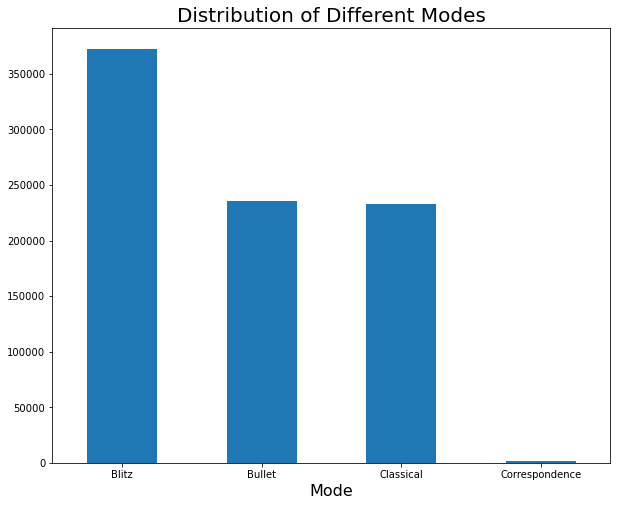

In [6]:
general_eda('Mode')

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Faster chess is most common online! Not surprising given that it's hard to keep focus during online games. </p>

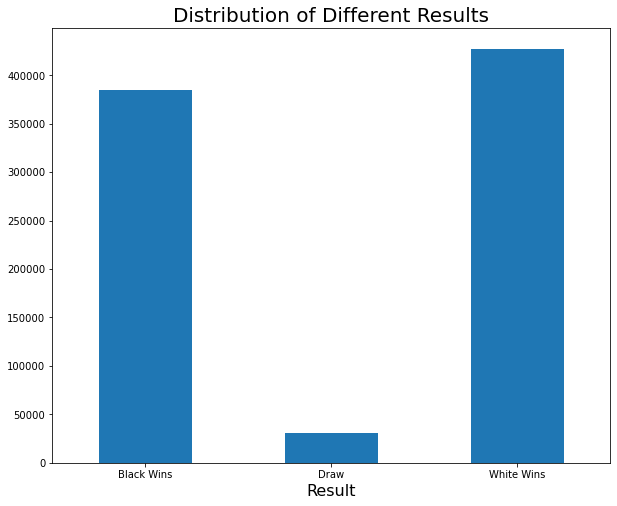

In [7]:
general_eda('Result')

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> On average, white wins more, a claim which is backed up by hundreds of years of empirical evidence regarding the immediate advantage the white player has. The amount of draws is quite low, implying that most online chess players will typically play out a drawn position until one of the players blunders.</p>

Termination Type
Abandoned               86
Normal              560233
Rules infraction        61
Time forfeit        282850
Name: Mode, dtype: int64


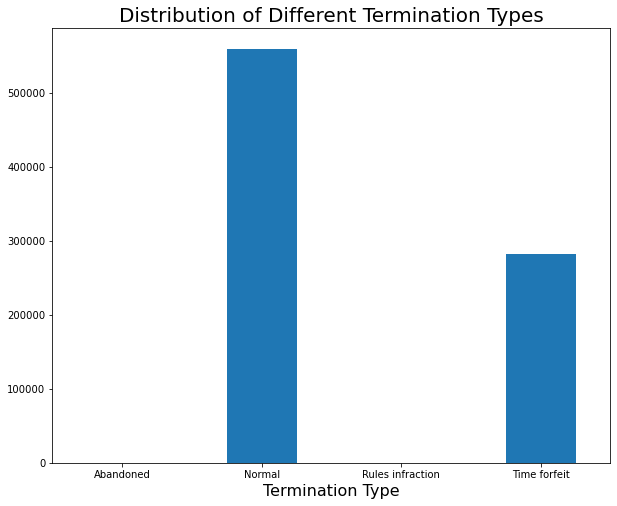

In [8]:
general_eda('Termination Type', print_now=True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> Interestingly, on an initial run through the data, I didn't realize that there were any termination types aside from normal termination and time forfeit. That's why an exploratory data analysis is so important! Games that are abandoned or face rules infractions won't be used for future visualizations, but they are still worth mentioning here so bugs don't arise in future code. </p>

Mean of Average Ratings: 1628.876
Median of Average Ratings: 1623.000
Standard Deviation of Average Ratings: 214.678
95% confidence interval: 1199.520 to 2058.231
95% of data is between 1225.725 and 2063.000
Skew of the distribution is 0.156


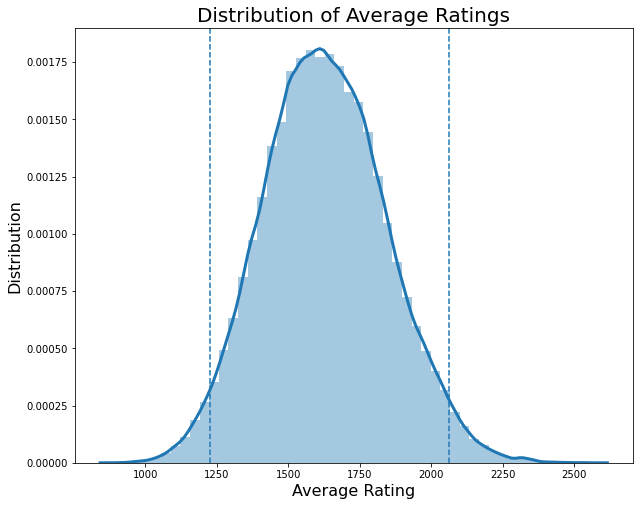

In [9]:
avg_rat = chess_df['Average Rating']
print("Mean of Average Ratings: %.3f" % np.mean(avg_rat))
print("Median of Average Ratings: %.3f" % np.median(avg_rat))
print("Standard Deviation of Average Ratings: %.3f" % np.std(avg_rat))
intv1 = np.mean(avg_rat)-2*np.std(avg_rat)
intv2 = np.mean(avg_rat)+2*np.std(avg_rat)
print("95%c confidence interval: %.3f to %.3f" % ('%', intv1, intv2))
quant1 = np.quantile(avg_rat, 0.025)
quant2 = np.quantile(avg_rat, 0.975)
print("95%c of data is between %.3f and %.3f" % ('%', quant1, quant2))
print("Skew of the distribution is %.3f" % (stats.skew(avg_rat)))

plt.figure(figsize=(10, 8))
sns.distplot(avg_rat, kde_kws={'linewidth': 3})
plt.axvline(x=quant1, linestyle='--', markersize=12)
plt.axvline(x=quant2, linestyle='--', markersize=12)
plt.xlabel("Average Rating", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Distribution of Average Ratings", fontsize=20)
plt.show()

In [10]:
print("Rating below 1250 (Beginner): %d" % (np.count_nonzero(avg_rat < 1250)))
print("Rating 1250 - 1750 (Intermediate): %d" % (np.count_nonzero(avg_rat < 1750) - np.count_nonzero(avg_rat < 1250)))
print("Rating 1750 - 2250 (Advanced): %d" % (np.count_nonzero(avg_rat < 2250) - np.count_nonzero(avg_rat < 1750)))
print("Rating above 2250 (Master): %d" % (np.count_nonzero(avg_rat >= 2250)))

Rating below 1250 (Beginner): 28184
Rating 1250 - 1750 (Intermediate): 574771
Rating 1750 - 2250 (Advanced): 237857
Rating above 2250 (Master): 2418


<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> The distribution above is right skewed, as seen by the positive skew given by the analysis. This means that there are, on average, more beginners learning how to play chess as opposed to seasoned experts in this dataset. This skew has most likely expanded since 2014, especially with the recent publicity of chess (e.g., Hikaru, PogChamps). So essentially, if you are new and interested in chess, <span style="font-weight: bold; color:green">don't be afraid to start playing! </span> There are plenty of beginners out there all trying to improve their skills through practice, so you won't be alone.</p>

Mean of Average Ratings: 6.529
Median of Average Ratings: 6.000
Standard Deviation of Average Ratings: 197.918
95% confidence interval: -389.307 to 402.366
95% of data is between -406.000 and 421.000
Skew of the distribution is 0.007
Kurtosis of the distribution is 1.969
Exccess kurtosis of the distribution is -1.031


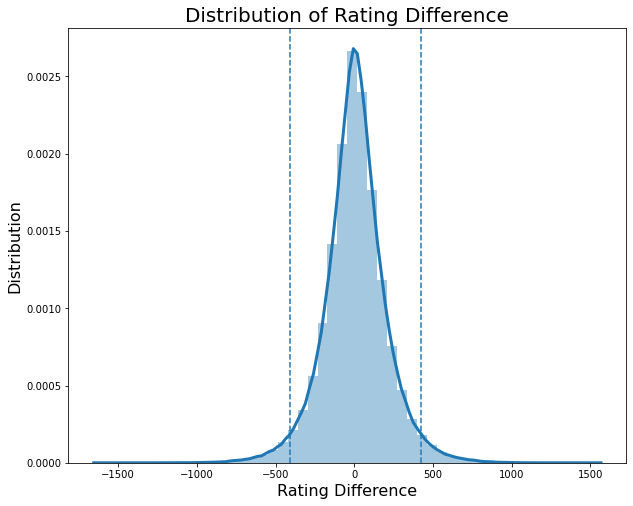

In [11]:
rating_diff = chess_df['Rating Difference']
print("Mean of Average Ratings: %.3f" % np.mean(rating_diff))
print("Median of Average Ratings: %.3f" % np.median(rating_diff))
print("Standard Deviation of Average Ratings: %.3f" % np.std(rating_diff))
intv1 = np.mean(rating_diff)-2*np.std(rating_diff)
intv2 = np.mean(rating_diff)+2*np.std(rating_diff)
print("95%c confidence interval: %.3f to %.3f" % ('%', intv1, intv2))
quant1 = np.quantile(rating_diff, 0.025)
quant2 = np.quantile(rating_diff, 0.975)
print("95%c of data is between %.3f and %.3f" % ('%', quant1, quant2))
print("Skew of the distribution is %.3f" % (stats.skew(rating_diff)))
print("Kurtosis of the distribution is %.3f" % (stats.kurtosis(rating_diff)))
print("Exccess kurtosis of the distribution is %.3f" % (stats.kurtosis(rating_diff)-3))

plt.figure(figsize=(10, 8))
sns.distplot(rating_diff, kde_kws={'linewidth': 3})
plt.axvline(x=quant1, linestyle='--', markersize=12)
plt.axvline(x=quant2, linestyle='--', markersize=12)
plt.xlabel("Rating Difference", fontsize=16)
plt.ylabel("Distribution", fontsize=16)
plt.title("Distribution of Rating Difference", fontsize=20)
plt.show()

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> It seems like the player on the white side is typically higher rated than the player on the black side. The distribution is platykurtic, since the excess kurotsis is negative; this means that we don't expect many extreme events near the tails of the distribution (no games with rating difference around -500 and 500). This makes sense, since Lichess' default rating difference search is 500, and most people will either keep it that way or decrease it to somewhere around 50. </p>

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="multiprocess">Foundation for Implementing Multiprocessing<a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#multiprocess">¶</a></h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> In this section, I create the foundation for using Python's multiprocessing package. I use multiprocessing for this notebook because the dataset is extremely large. With four cores (what most computers have), we can speed up the visualization process by a factor of 4, just with a bit of extra coding. <span style="color:green"> Essentially, this is some foundational code for speeding up the visualization process (by a factor of 2-4).</span></p>

In [12]:
splits = multiprocessing.cpu_count()

def multi_split(chess_df, splits):
    if __name__ == "__main__":
        length = len(chess_df)
        steps = math.ceil(length/splits)
        input_games = []
        for x in range(splits):
            input_games.append(chess_df[steps*x:steps*(x+1)].reset_index())
    
    return input_games

input_games = multi_split(chess_df, splits)

In [13]:
print("First %d arrays have dimensions %d by %d" % (splits-1, len(input_games), len(input_games[0])))
print("Last array has dimension %d by %d" % (len(input_games), len(input_games[splits-1])))

First 3 arrays have dimensions 4 by 210808
Last array has dimension 4 by 210806


<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="gamelength">Distribution of Chess Game Lengths <a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#gamelength">¶</a></h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> The average chess game length is said to be around 40, but did you know the longest chess game (over the board) ever was <a href="https://www.chesspower.co.nz/chess-records.html#:~:text=The%20longest%20chess%20game%20is,game%20lasted%20over%2020%20hours."> 269 moves? </a> In this section, I delve into the distribution of game lengths in this dataset. </p>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> Algorithm: I calculate the game length below by keeping track of an length iterator which is increased by 1 for every 3 spaces. For example, a game with standard PGN notation may look like "1. e4 e5 2. Nf3 Nc6", and so every three spaces would indicate a new move. </p>

In [14]:
length_arr = []

for game in chess_df['PGN']:
    curr_length = 1
    spaces = 0
    for index in range(len(game)):
        if game[index] == " ":
            spaces += 1
            if spaces == 3:
                curr_length += 1
                spaces = 0
        index += 1
    length_arr.append(curr_length)
    
chess_df['Moves'] = length_arr

In [15]:
%%time
length_arr = []

for game in chess_df['PGN']:
    curr_length = 1
    spaces = 0
    for index in range(len(game)):
        if game[index] == " ":
            spaces += 1
            if spaces == 3:
                curr_length += 1
                spaces = 0
        index += 1
    length_arr.append(curr_length)
    
chess_df['Moves'] = length_arr

CPU times: user 1min 2s, sys: 16.6 ms, total: 1min 2s
Wall time: 1min 2s


In [16]:
# Recreate input_games
del input_games
input_games = multi_split(chess_df, splits)

In [17]:
def visualize_length(all_lengths, max_length):
    print("Mean Length: %.3f" % np.mean(all_lengths))
    print("Median Length: %.3f" % np.median(all_lengths))
    print("Standard Deviation: %.3f" % np.std(all_lengths))
    print("Longest Game in Dataset: %d moves" % max(all_lengths))
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    sns.distplot(all_lengths, bins, kde_kws = {'linewidth': 3})
    plt.xlim(0, max_length)
    print("Number of Games that are 1 moves long: %.d\nNumber of Games that are 2 moves long: %.d" % (all_lengths.count(1), all_lengths.count(2)))
    
    return np.mean(all_lengths)

Mean Length: 33.785
Median Length: 32.000
Standard Deviation: 15.841
Longest Game in Dataset: 191 moves
Number of Games that are 1 moves long: 6978
Number of Games that are 2 moves long: 5775


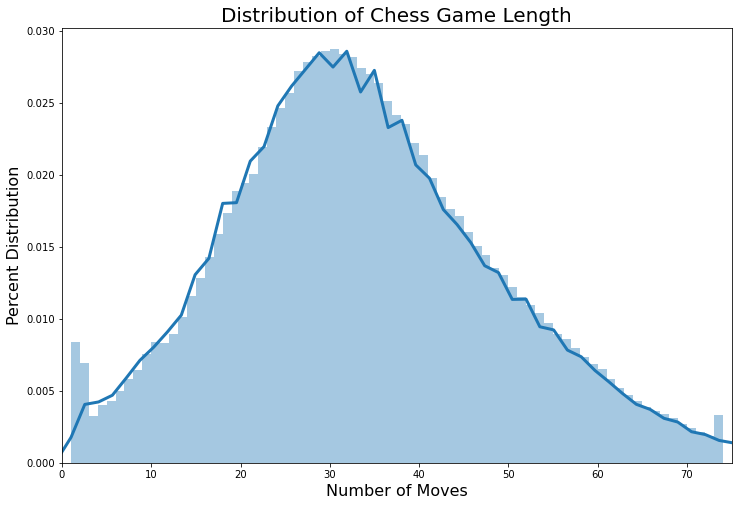

In [18]:
max_moves = 75
mean_length = visualize_length(chess_df['Moves'].tolist(), max_moves)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> The mean and median of chess game lengths seem to hover around the mid 30s range, somewhat lower than our expected average of ~40 moves per game. This is probably due to the fact this dataset includes speed chess (games with time control less than 5 minutes), so players may flag more often than a game that is played over the board. One thing I found particularly interesting with this distribution is the number of games that are 1 and 2 moves long. Perhaps this is because some people will leave their games, thus resulting in a time forfeit. </p>

In [19]:
def termination_game_length(games):
    length_tf = []
    length_normal = []
    for i in range(len(games['PGN'])):
        curr_length = games['Moves'][i]
        if games['Termination Type'][i] == 'Time forfeit':
            length_tf.append(curr_length)
        else:
            length_normal.append(curr_length)
    
    return length_tf, length_normal

%time termination_length_list = termination_game_length(chess_df)

CPU times: user 10.1 s, sys: 28.9 ms, total: 10.1 s
Wall time: 10.1 s


In [20]:
def termination_visualize_length(termination_length_list, max_length, shade=False):
    all_lengths = []
    termination_list = []
    for length in termination_length_list[0]:
        termination_list.append(length)
         
    normal_list = []
    for length in termination_length_list[1]:
        normal_list.append(length)
            
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length with Different Terminations", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    if shade:
        sns.distplot(termination_list, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
        sns.distplot(normal_list, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
    else:
        print("Mean Length Time Forfeit: %.3f" % np.mean(termination_list))
        print("Mean Length Normal: %.3f" % np.mean(normal_list))
        print("Median Length Time Forfeit: %.3f" % np.median(termination_list))
        print("Median Length Normal: %.3f" % np.median(normal_list))
        sns.distplot(termination_list, bins, kde_kws = {'linewidth': 3})
        sns.distplot(normal_list, bins, kde_kws = {'linewidth': 3})
    plt.xlim(0, max_length)
    plt.legend(["Time forfeit", "Normal"])

Mean Length Time Forfeit: 34.980
Mean Length Normal: 33.182
Median Length Time Forfeit: 35.000
Median Length Normal: 31.000


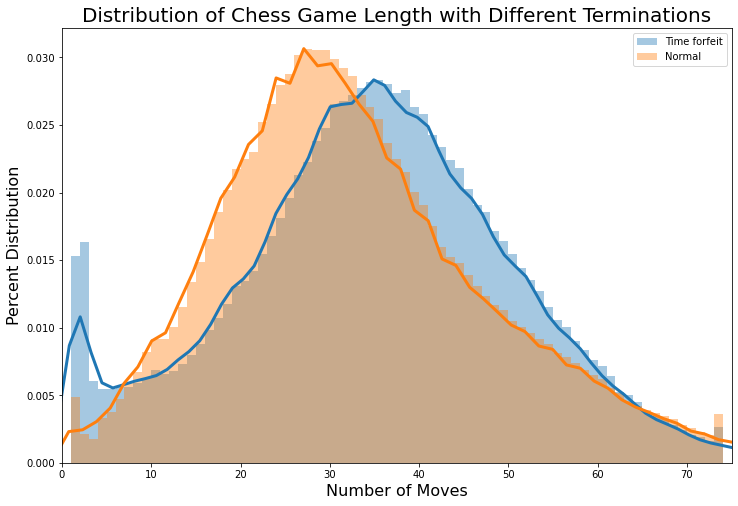

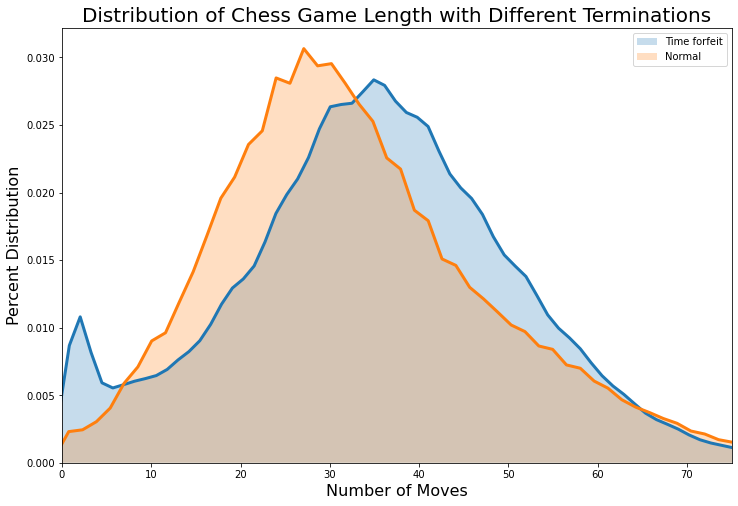

In [21]:
termination_visualize_length(termination_length_list, max_moves)
termination_visualize_length(termination_length_list, max_moves, shade=True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> We can see that the previous hypothesis that most of the early forfeits are due to time forfeits (e.g. someone leaves to eat dinner and loses on time). Interestingly though, the average number of moves for a game that ends in time forfeit is larger than a normal game. This might be due to people not resigning in bullet games to flag their opponents (eventually someone loses on time) or selection bias, where people who resign will most likely resign somewhere in the middlegame (move 25 to 35) as opposed to later in the game when all hope is lost.</p>

In [22]:
def mode_game_length(games, labels_list):
    mode_dict = {}
    for label in labels_list:
        mode_dict[label] = []
        
    for i in range(len(games['PGN'])):
        curr_length = games['Moves'][i]
        mode_dict[games['Mode'][i]].append(curr_length)
    
    return mode_dict

labels_list = ['Bullet', 'Blitz', 'Classical', 'Correspondence']
mode_length_list = mode_game_length(chess_df, labels_list)

In [23]:
def mode_visualize_length(mode_length_list, max_length, labels_list, shade=False):
    mode_dict = [[] for i in range(len(labels_list))]
    r = 0
    for mode in mode_length_list:
        for length in mode_length_list[mode]:
            mode_dict[r].append(length)
        r += 1
            
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length with Different Modes", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    if shade:
        for mode in mode_dict:
            sns.distplot(mode, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
    else:
        for mode in mode_dict:
            sns.distplot(mode, bins, kde_kws = {'linewidth': 3})
        r = 0
        for label in labels_list:
            print("%s Mean: %.3f" % (label, np.mean(mode_dict[r])))
            r += 1
    plt.legend(labels_list)
    plt.xlim(0, max_length)

Bullet Mean: 32.647
Blitz Mean: 34.907
Classical Mean: 33.167
Correspondence Mean: 30.698


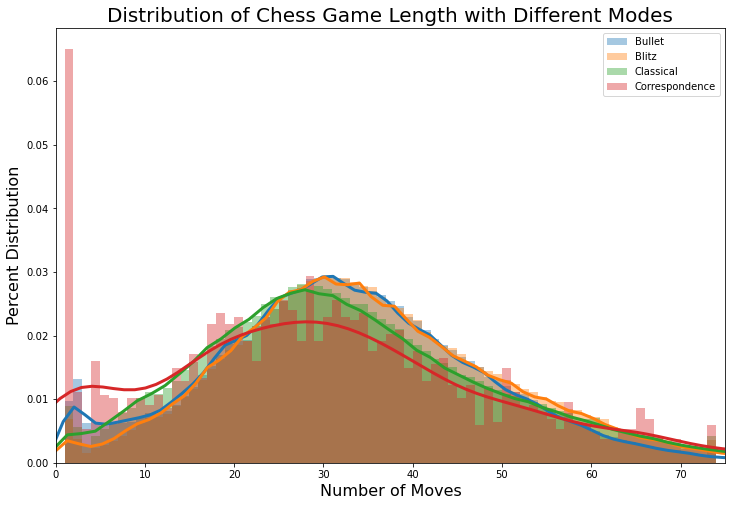

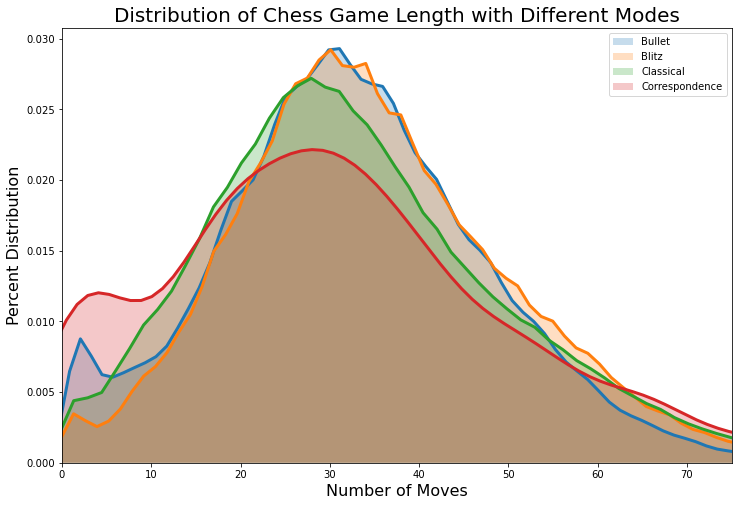

In [24]:
mode_visualize_length(mode_length_list, max_moves, labels_list)
mode_visualize_length(mode_length_list, max_moves, labels_list, shade=True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Well, it looks like the reason there's an outlier for how many games end within the first 2 moves is because of correspondence! I guess if a person decides not to play in correspondence, they lose on time. Aside from that, the distribution looks pretty normal, with no noticeable outliers.</p>

In [25]:
def rating_game_length(games, rating_range=[750, 1250, 1750, 2250]):
    rating_dict = {}
    for rating in rating_range:
        rating_dict[rating] = []
        
    for i in range(len(games['PGN'])):
        rating_type = -1
        for j in range(len(rating_range)):
            if j == 0:
                continue
            if games['Average Rating'][i] > rating_range[j]:
                rating_type = rating_range[j-1]
                
        if rating_type == -1:
            rating_type = 2250
        
        curr_length = games['Moves'][i]
        rating_dict[rating_type].append(curr_length)
    
    return rating_dict

labels_list = ['Bullet', 'Blitz', 'Classical', 'Correspondence']
rating_length_list = rating_game_length(chess_df)

In [26]:
def rating_visualize_length(rating_length_list, max_length, rating_range=[750, 1250, 1750, 2250], shade=False):
    rating_dict = [[] for i in range(len(rating_range))]
    r = 0
    for rating in rating_length_list:
        for length in rating_length_list[rating]:
            rating_dict[r].append(length)
        r += 1
            
    plt.figure(figsize=(12, 8))
    bins = np.arange(0, max_length, 1)
    plt.title("Distribution of Chess Game Length with Different Ratings", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percent Distribution", fontsize=16)
    if shade:
        for rating in rating_dict:
            sns.distplot(rating, bins, hist=False, kde_kws = {'linewidth': 3, 'shade': True})
    else:
        for rating in rating_dict:
            sns.distplot(rating, bins, kde_kws = {'linewidth': 3})
        r = 0
        for rating in rating_range:
            print("%s+ Mean: %.3f" % (rating, np.mean(rating_dict[r])))
            r += 1
    
    label_range = []
    for rating in rating_range:
        label_range.append(str(rating) + '+')
    plt.legend(label_range)
    plt.xlim(0, max_length)

750+ Mean: 32.939
1250+ Mean: 36.551
1750+ Mean: 41.407
2250+ Mean: 27.293


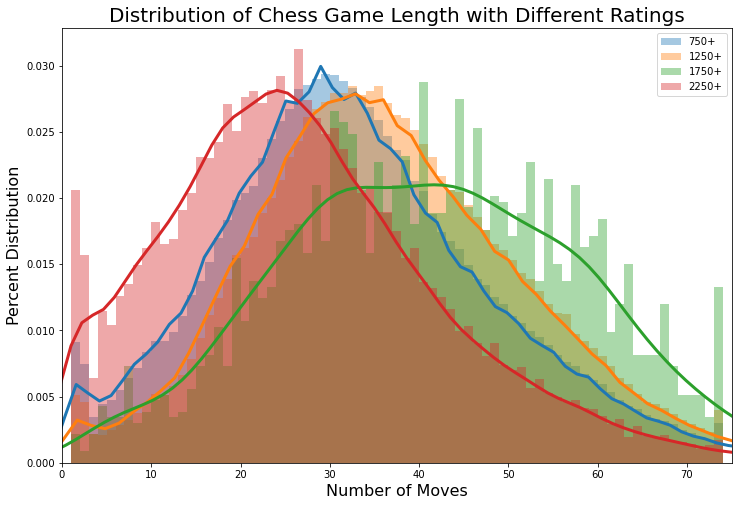

In [27]:
rating_visualize_length(rating_length_list, max_moves)

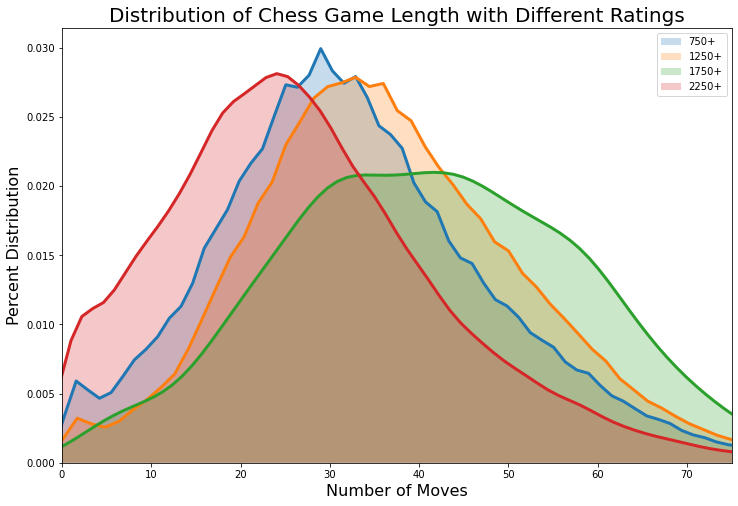

In [28]:
rating_visualize_length(rating_length_list, max_moves, shade=True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Finally, we can see that, on average, master players tend to have shorter games, and intermediate/advanced players have the longest games. This may be because master players will resign earlier when they know a situation is hopeless, beginner players may resign earlier when they blunder, but intermediate/advanced players may continue playing the game through on the premise that their opponent will blunder at some point.</p>

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="piecemovement">How many times does each piece move?<a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#piecemovement">¶</a></h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> The first thing I thought about analyzing was: "how many times does a specific chess piece move in a chess game?" A pawn moves seems to be the most likely candidate for "most moved", but what about the minor pieces (knight and bishop) versus the queen? There are two minor pieces for each side, but the queen is almighty...</p>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> The algorithm below utilizes a boolean "states" operator, curr_move. When curr_move is set to False, then I take the next letter in the string and use it to increment a dictionary.</p>

In [29]:
def total_moves(games):
    moves_dict = {'P': 0, 'B': 0, 'N': 0, 'R': 0, 'Q': 0, 'K': 0, 'O': 0}
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    pieces = ['B', 'N', 'R', 'Q', 'K', 'O']
    for game in games['PGN']:
        curr_move = False
        for index in range(len(game)):
            if game[index] == " ":
                curr_move = False
            elif curr_move:
                continue
            elif game[index] in pawn:
                moves_dict['P'] += 1
                curr_move = True
            elif game[index] in pieces:
                moves_dict[game[index]] += 1
                curr_move = True
    
    return moves_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time moves_list = pool.map(total_moves, input_games)

CPU times: user 1.59 s, sys: 1.36 s, total: 2.95 s
Wall time: 37 s


In [30]:
def visualize_moves(moves_list, vis_percentage=True, average=False):
    # Preprocessing
    labels = ['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King', 'Castling']
    M_dict = {}
    for label in moves_list[0]:
        M_dict[label] = 0

    for moves_dict in moves_list:
        for piece in moves_dict:
            M_dict[piece] += moves_dict[piece]

    summ = 0
    for piece in M_dict:
        summ += M_dict[piece]

    M_list = []
    for piece in M_dict:            
        if vis_percentage:
            M_list.append(M_dict[piece]/summ*100)
        else:
            avg = 1
            if average:
                avg = len(chess_df)
            M_list.append(M_dict[piece]/avg)

    # Plotting
    label_pos = np.arange(len(labels))
    plt.figure(figsize=(10, 8))
    plt.title("How many times does each chess piece move?", fontsize=20)
    bar_width = 0.35
    plt.bar(label_pos, M_list, bar_width)
    plt.xticks(label_pos, labels, fontsize=16)
    if vis_percentage:
        plt.ylabel('Percentage', fontsize=16)
    elif average:
        plt.ylabel("Average Number of Moves Per Chess Game", fontsize=16)
        plt.yticks(np.arange(0, 21, 1))
    else:
        plt.ylabel('Total Number of Moves', fontsize=16)
    plt.show()

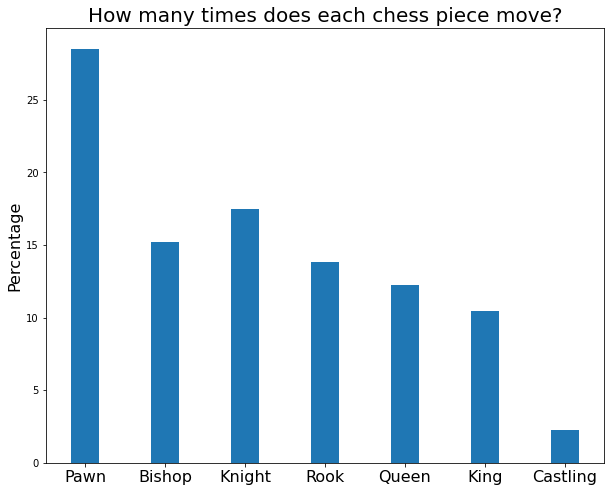

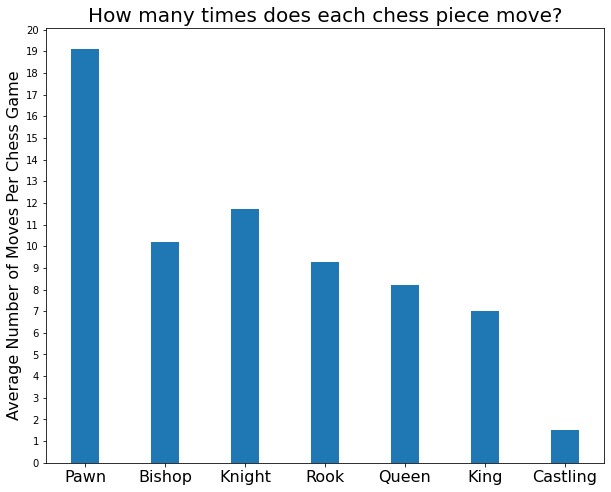

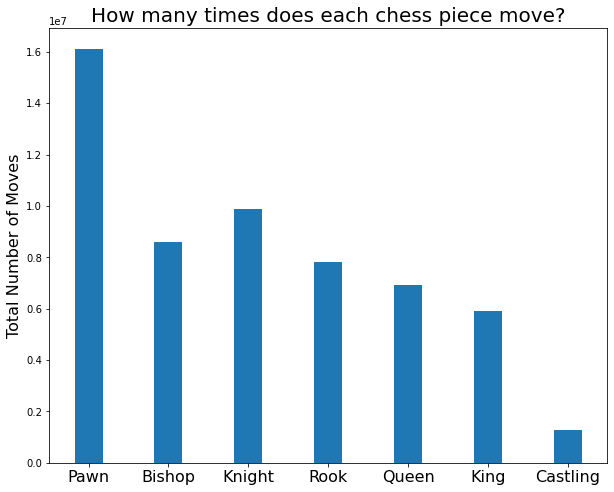

In [31]:
visualize_moves(moves_list)
visualize_moves(moves_list, vis_percentage=False, average=True)
visualize_moves(moves_list, vis_percentage=False, average=False)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Just like expected, pawn moves dominate chess games, of course, since there are at most 16 pawns on the board, compared to the at most 4 for any other piece. Somewhat surprising is that there are more knight moves than bishop moves; maybe knights are more powerful than bishops after all! The singular queen also moves around quite alot, but that isn't surprising, since the queen is powerful and can travel across the chessboard in an instant. </p>

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="piecemovement2">On any given move, what is the probability a specific chess piece moves?<a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#piecemovement2">¶</a></h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> So we've found how many times a chess piece moves, but what about over the course of a chess game? Are pawn moves more likely at the beginning of a chess game or towards the end of a chess game? We know that the king loves coming to the center of the board near the endgame, so are we going to see a sudden spike of king moves at the end of the game? Well, you'll just have to keep reading to find out...</p>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> The algorithm used below is a synthesis of the previous two algorithms, with both the move number and what piece is moving being considered.</p>

In [32]:
def prob_over_time(games, max_moves):
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    pieces = ['B', 'N', 'R', 'Q', 'K', 'O']    
    time_dict = {}
    for i in range(1, max_moves+1):
        time_dict[i] = {'P': 0, 'B': 0, 'N': 0, 'R': 0, 'Q': 0, 'K': 0, 'O': 0}
    
    for game in games['PGN']:
        curr_move = False
        curr_length = 1
        spaces = 0
        for index in range(len(game)):
            if game[index] == " ":
                spaces += 1
                if spaces == 3:
                    if curr_length < max_moves:
                        curr_length += 1
                    spaces = 0
                curr_move = False
            elif curr_move:
                continue
            elif game[index] in pawn:
                time_dict[curr_length]['P'] += 1
                curr_move = True
            elif game[index] in pieces:
                time_dict[curr_length][game[index]] += 1
                curr_move = True

    return time_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time time_list = pool.map(partial(prob_over_time, max_moves=max_moves), input_games)

CPU times: user 1.57 s, sys: 1.27 s, total: 2.84 s
Wall time: 40.6 s


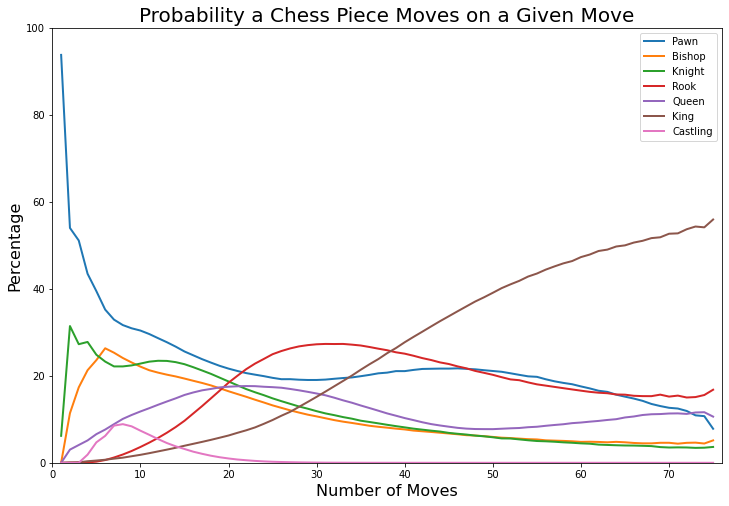

In [33]:
def visualize_prob_over_time(time_list, max_moves):
    # Preprocessing
    labels = ['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King', 'Castling']
    T_dict = [[0 for j in range(max_moves)] for i in range(len(labels))]
    
    for time_dict in time_list:
        for time in time_dict:
            r = 0
            for piece in time_dict[time]:
                T_dict[r][time-1] += time_dict[time][piece]
                r += 1
                
    for i in range(max_moves):
        summ = 0
        for t in range(len(labels)):
            summ += T_dict[t][i]
        
        for t in range(len(labels)):
            T_dict[t][i] /= summ/100
    
    plt.figure(figsize=(12, 8))
    
    for i in range(len(labels)):
        plt.plot(np.arange(1, max_moves+1, 1), T_dict[i], linewidth=2)
    
    plt.legend(labels)
    plt.xlim(0, max_moves+1)
    plt.ylim(0, 100)
    plt.title("Probability a Chess Piece Moves on a Given Move", fontsize=20)
    plt.xlabel("Number of Moves", fontsize=16)
    plt.ylabel("Percentage", fontsize=16)
    
visualize_prob_over_time(time_list, max_moves)

In [34]:
def rating_prob_over_time(games, max_moves, rating_range):
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    pieces = ['B', 'N', 'R', 'Q', 'K', 'O']    
    
    rating_dict = {}
    for rat in range(len(rating_range)+1):
        time_dict = {}
        for i in range(1, max_moves+1):
            time_dict[i] = {'P': 0, 'B': 0, 'N': 0, 'R': 0, 'Q': 0, 'K': 0, 'O': 0}
        rating_dict[rat] = time_dict
    
    r = 0
    for game in games['PGN']:
        curr_move = False
        curr_length = 1
        spaces = 0
        
        curr_avg_rating = games['Average Rating'][r]
        rating_index = 0
        for rat in rating_range:
            if curr_avg_rating < rat:
                break
            else:
                rating_index += 1
                
        for index in range(len(game)):
            if game[index] == " ":
                spaces += 1
                if spaces == 3:
                    if curr_length < max_moves:
                        curr_length += 1
                    spaces = 0
                curr_move = False
            elif curr_move:
                continue
            elif game[index] in pawn:
                rating_dict[rating_index][curr_length]['P'] += 1
                curr_move = True
            elif game[index] in pieces:
                rating_dict[rating_index][curr_length][game[index]] += 1
                curr_move = True
        r += 1

    return rating_dict

with multiprocessing.Pool(processes=splits) as pool:
    rating_range = [1250, 1750, 2250]
    %time rating_time_list = pool.map(partial(rating_prob_over_time, max_moves=max_moves, rating_range=rating_range), input_games)

CPU times: user 1.58 s, sys: 1.24 s, total: 2.82 s
Wall time: 48.6 s


In [35]:
def visualize_rating_prob_over_time(rating_time_list, max_moves, rating_range, players=False):
    plt.rcParams.update({'figure.max_open_warning': 0})
    # Preprocessing
    labels = ['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King', 'Castling']
    R_dict = [[[0 for j in range(max_moves)] for i in range(len(labels))] for k in range(len(rating_range)+1)]
    
    for rating_dict in rating_time_list:
        for rat in rating_dict:
            for time in rating_dict[rat]:
                r = 0
                for piece in rating_dict[rat][time]:
                    R_dict[rat][r][time-1] += rating_dict[rat][time][piece]
                    r += 1
    
    for rat in range(len(R_dict)):            
        for i in range(max_moves):
            summ = 0
            for t in range(len(labels)):
                summ += R_dict[rat][t][i]

            for t in range(len(labels)):
                if summ == 0:
                    summ = 1
                R_dict[rat][t][i] /= summ/100
    
    rating_labels = ['Beginner', 'Intermediate', 'Advanced', 'Master']
    
    if not players:
        fig, ax = plt.subplots(int((len(rating_range)+1)/2), 2, figsize=(20, 15))
        for j in range(len(rating_range)+1):
            ind1 = int(j/2)
            ind2 = j%2
            for i in range(len(labels)):
                ax[ind1][ind2].plot(np.arange(1, max_moves+1, 1), R_dict[j][i], linewidth=2)
            ax[ind1][ind2].legend(labels)
            ax[ind1][ind2].set_xlim(0, max_moves+1)
            ax[ind1][ind2].set_ylim(0, 100)
            ax[ind1][ind2].set_title("Chess Piece Movement for %s Players" % (rating_labels[j]), fontsize=20)
            ax[ind1][ind2].set_xlabel("Number of Moves", fontsize=16)
            ax[ind1][ind2].set_ylabel("Percentage", fontsize=16)
    else: 
        fig, ax = plt.subplots(len(labels), 1, figsize=(10, 8*len(labels)))
        for i in range(len(labels)):
            for j in range(len(rating_range)+1):
                plt.figure(figsize=(12, 8))
                ax[i].plot(np.arange(1, max_moves+1, 1), R_dict[j][i], linewidth=2)
                ax[i].set_title("%s Movement Comparison" % labels[i], fontsize=20)
                ax[i].set_xlim(0, max_moves+1)
                ax[i].set_ylim(bottom=0)
                ax[i].autoscale(enable=True)
                ax[i].set_xlabel("Number of Moves", fontsize=16)
                ax[i].set_ylabel("Percentage", fontsize=16)
                ax[i].legend(rating_labels)
                
    plt.show()

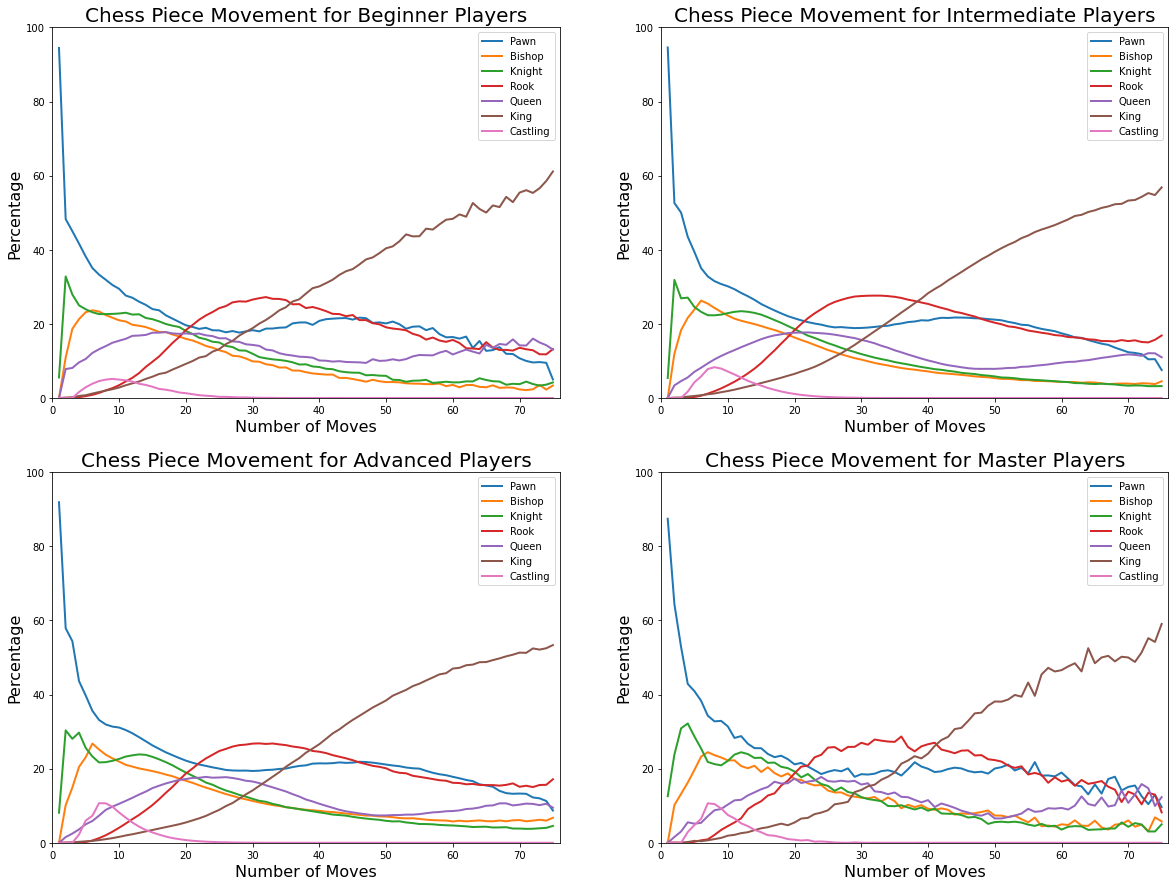

In [36]:
visualize_rating_prob_over_time(rating_time_list, max_moves, rating_range)

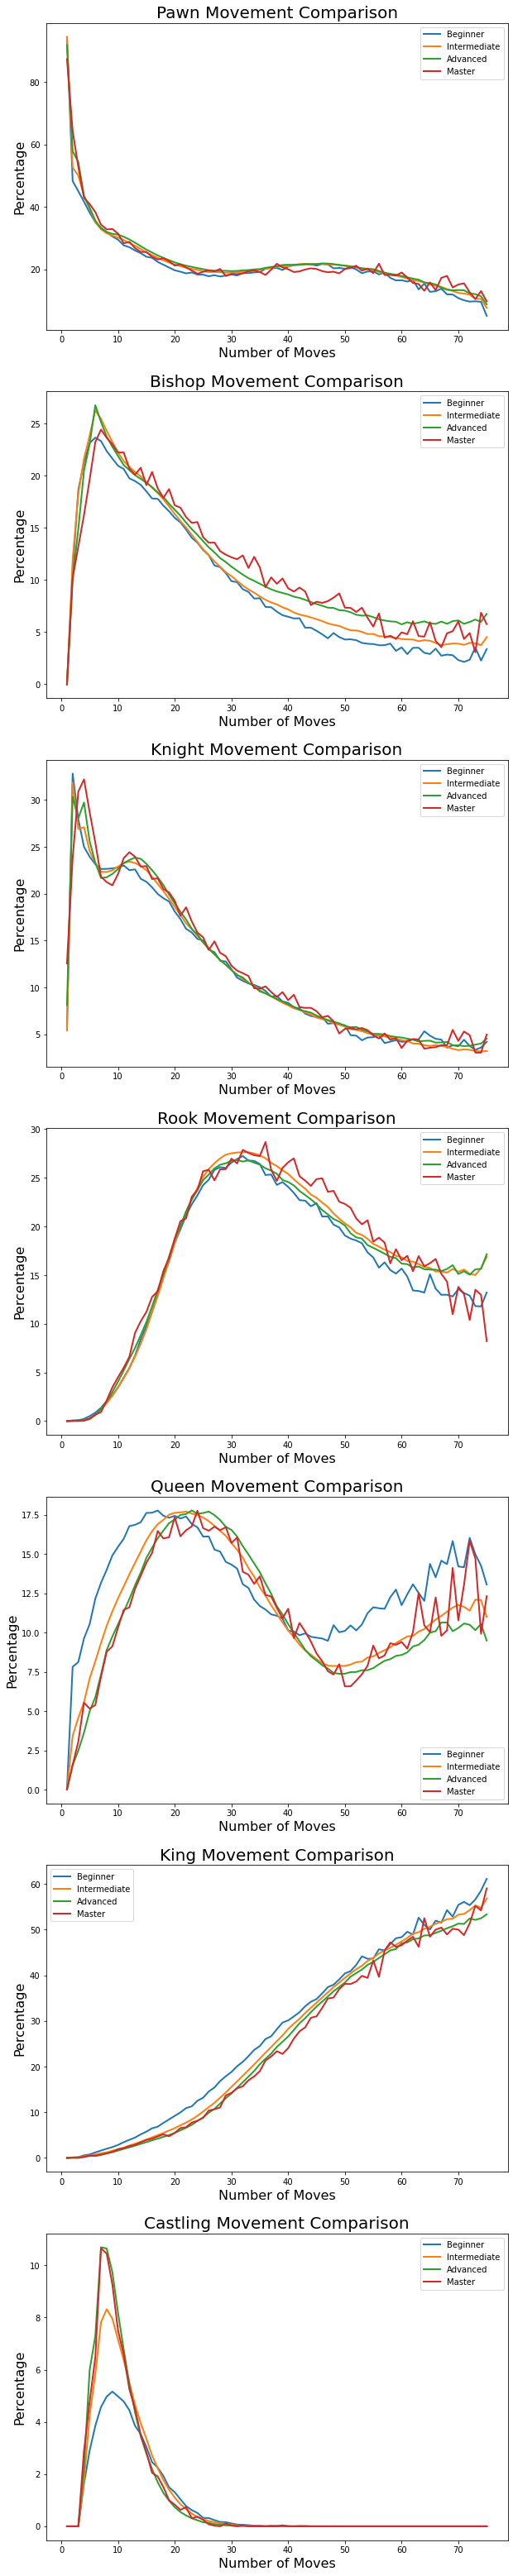

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [37]:
visualize_rating_prob_over_time(rating_time_list, max_moves, rating_range, players=True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> Beginner players seem to move their queen way too often in the opening, neglecting castling. <span style="font-weight:bold"> Don't do that! </span>Castle so your king is safe, develop all of your pieces, and only THEN begin moving your queen to attack your opponent's position.</p>

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="square">What is the probability a piece lands on a certain square?<a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#square">¶</a></h1>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px"> This is my favorite part of the entire visualization. Where do pieces love moving the most? Is bishop to c4 more common than bishop to d3? What about queen moves? You may be surprised...!</p>
    
<p style="font-size:15px; font-family:verdana; line-height: 1.7em; padding-top: 15px">The algorithm below searches through the PGN and involves many if-statement checks to remove weird edge cases like exd1=Q+. I've tried my best to include comments in my code so what I'm doing makes sense.</p>

In [38]:
def piece_prob(games, castling=False):
    prob_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    #chessboard representation in dict form, must recreate each dict b/c of how python dicts work
    for p in pieces:
        chess_dict = {}
        for horizontal in pawn:
            for vertical in range(1, 9):
                chess_dict[horizontal+str(vertical)] = 0
        prob_dict[p] = chess_dict

    for game in games['PGN']:
        curr_move = False
        s = ""
        piece_id = ""
        for index in range(len(game)):
            if game[index] == " " and curr_move:
                if piece_id == 'O':
                    white = 1-white
                    continue
                    
                curr_move = False
                if len(s) >= 4:
                    # Determine whether move is a promotion, e.g. e8=Q
                    s1 = s[0:2]
                    
                    # Some anomalies, like exd1=Q+ cannot be solve without manually going through the string and trying possibilities
                    try:
                        prob_dict[piece_id][s1] += 0
                    except:
                        s1 = s[1:3]
                elif len(s) == 3:
                    # Determine whether is a move that isn't just a piece to a square, e.g. Ngf6 (which is read as gf6) or exf6 (which is read as ef6)
                    s1 = s[len(s)-2:len(s)]
                else:
                    s1 = s
                
                # Ensure the string is made correctly
                try:
                    prob_dict[piece_id][s1] += 1
                except:
                    print(game)
                    raise Exception("There is an error in the code at this game.")
                
                # Reset string
                s = "" 
            elif curr_move:
                if game[index] != 'x' and game[index] != '+' and game[index] != '#' and game[index] != '!' and game[index] != '?':
                    # Captures, checks, checkmates, and other notation do not affect where a piece moves
                    s += game[index]
            elif game[index] in pawn:
                piece_id = 'P' 
                curr_move = True
                # If the move is a pawn, then the current character is actually part of its movement
                s += game[index]
            elif game[index] in pieces:
                piece_id = game[index]
                curr_move = True
            elif game[index] == 'O' and castling:
                try:
                    if game[index+1] == '-':
                        if game[index+3] == '-':
                            # Queenside castling
                            if game[index-2] == '.':
                                prob_dict['K']['c1'] += 1
                                prob_dict['R']['d1'] += 1
                            else:
                                prob_dict['K']['c8'] += 1
                                prob_dict['R']['d8'] += 1
                        else:
                            # Kingside castling
                            if game[index-2] == '.':
                                prob_dict['K']['g1'] += 1
                                prob_dict['R']['f1'] += 1
                            else:
                                prob_dict['K']['g8'] += 1
                                prob_dict['R']['f8'] += 1
                except:
                    pass

    return prob_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time prob_list = pool.map(partial(piece_prob, castling=False), input_games)

CPU times: user 1.63 s, sys: 1.2 s, total: 2.83 s
Wall time: 1min 14s


In [39]:
def visualize_piece_prob(prob_list, visualize_list_raw=['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King'], vis_percentage=True, seaborn=True):
    """
    Driver function for visualizing the probability that each chess piece lands on a certain square
    Utilizes seaborn heatmap, if set to false, will use matplotlib heatmap
    """
    P_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    for p in pieces:
        chess_dict = {}
        for horizontal in pawn:
            for vertical in range(1, 9):
                chess_dict[horizontal+str(vertical)] = 0
        P_dict[p] = chess_dict

    for prob_dict in prob_list:
        for piece in prob_dict:
            for key in prob_dict[piece]:
                P_dict[piece][key] += prob_dict[piece][key]
    
    visualize_list = []
    for label in visualize_list_raw:
        if label == 'Knight':
            visualize_list.append('N')
        else:
            visualize_list.append(label[0])
    
    if seaborn:
        fig, ax = plt.subplots(len(visualize_list), figsize=(12, len(visualize_list)*8))
        r = 0
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(val_list[i+8*j]/summ)
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            heatmap = sns.heatmap(plot_list, cmap='YlOrRd', annot=True, fmt=".3%" if vis_percentage else "d", ax=ax[r], 
                                  cbar_kws={'label': 'Proportion (out of 1)' if vis_percentage else 'Raw Count'})
            ax[r].set_title("%s of %s Moving to Square on Chessboard" % ('Probability' if vis_percentage else 'Raw Count', visualize_list_raw[r]), fontsize=16)
            ax[r].set_xticklabels(pawn, fontsize=14)
            ax[r].set_yticklabels(np.arange(8, 0, -1), fontsize=14)
            r += 1

        fig.tight_layout()
        plt.subplots_adjust(hspace=0.2)
        plt.show()
    else:    
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(round(val_list[i+8*j]/summ*100, 3))
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            plt.figure(figsize=(12, 8))
            plt.imshow(plot_list, cmap='YlOrRd', interpolation='nearest')
            cbar = plt.colorbar()
            if vis_percentage:
                cbar.set_label("Probability (Percentage)", rotation=270, fontsize=16, labelpad=20)
            else:
                cbar.set_label("Raw Count", rotation=270, fontsize=16, labelpad=20)
            for i in range(8):
                for j in range(8):
                    tmp_str = str(plot_list[i][j])
                    if vis_percentage:
                        tmp_str += "%"

                    plt.text(j, i, tmp_str, ha="center", va="center", color="black")

            plt.title("%s of %s Moving to Square on Chessboard" % ('Probability' if vis_percentage else 'Raw Count', piece), fontsize=16)
            plt.xticks(np.arange(0, 8), pawn, fontsize=14)
            plt.yticks(np.arange(0, 8), np.arange(8, 0, -1), fontsize=14)

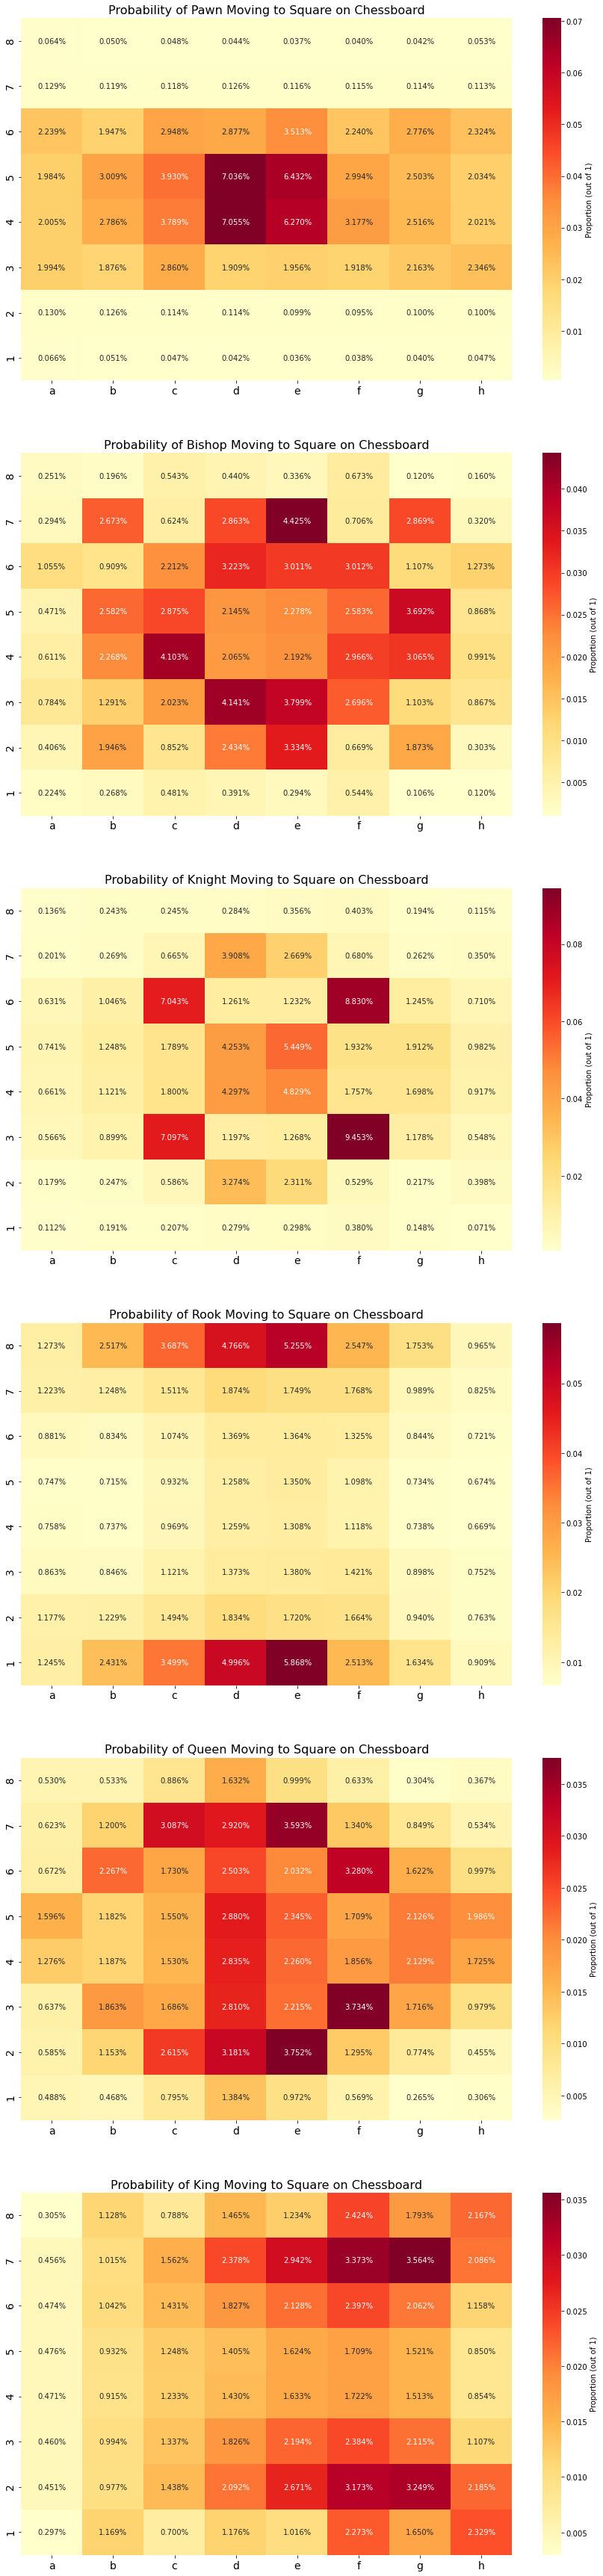

In [40]:
visualize_piece_prob(prob_list)

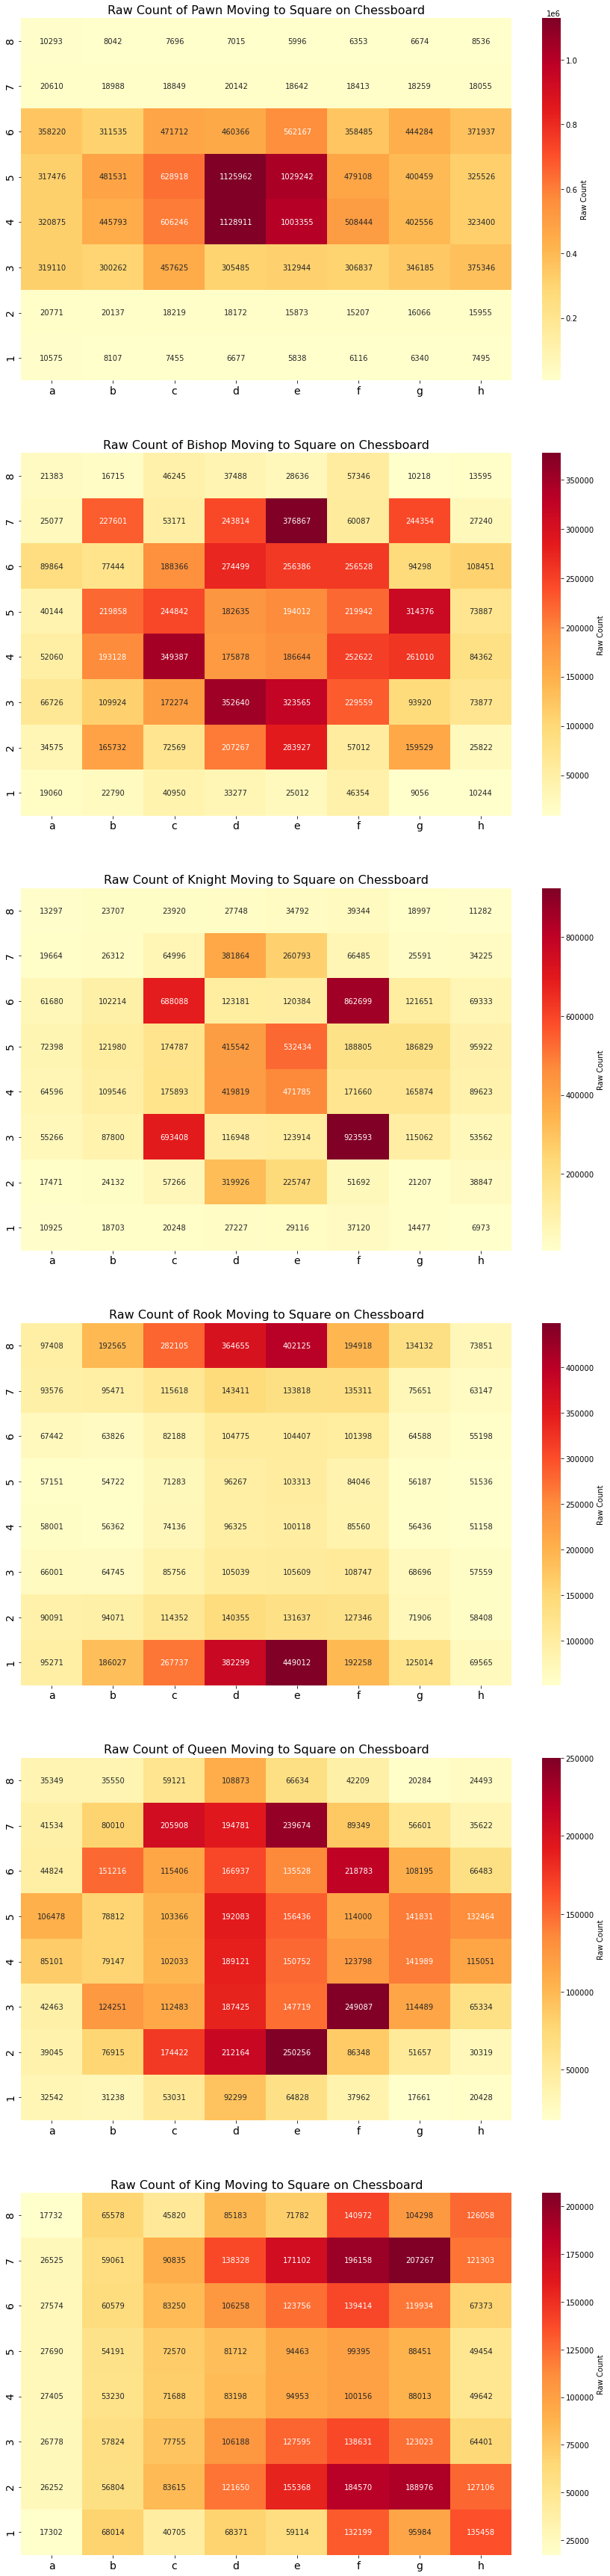

In [41]:
visualize_piece_prob(prob_list, vis_percentage=False)

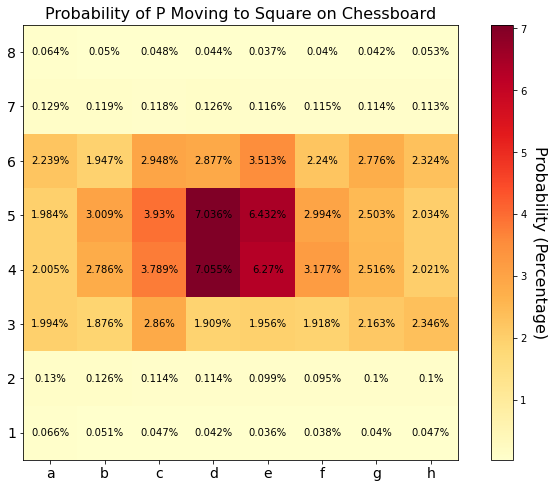

In [42]:
visualize_piece_prob(prob_list, visualize_list_raw=['Pawn'], seaborn=False)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> From these visualizations, the main lesson to learn is to always <span style="font-weight: bold">control the center!</span> Pieces move most fluidly towards and away from the center, so if you have a strong grasp of the center, you really limit what your opponent is able to accomplish. For the rest of this combined data (where the movement of white vs black is not separated), the data is alot to digest and very unclear, and so in the proceeding sections, I'll be splitting the movement up for into two graphs, one for white and one for black, and performing analysis on the much simpler data.</p>

CPU times: user 1.61 s, sys: 1.23 s, total: 2.85 s
Wall time: 1min 15s


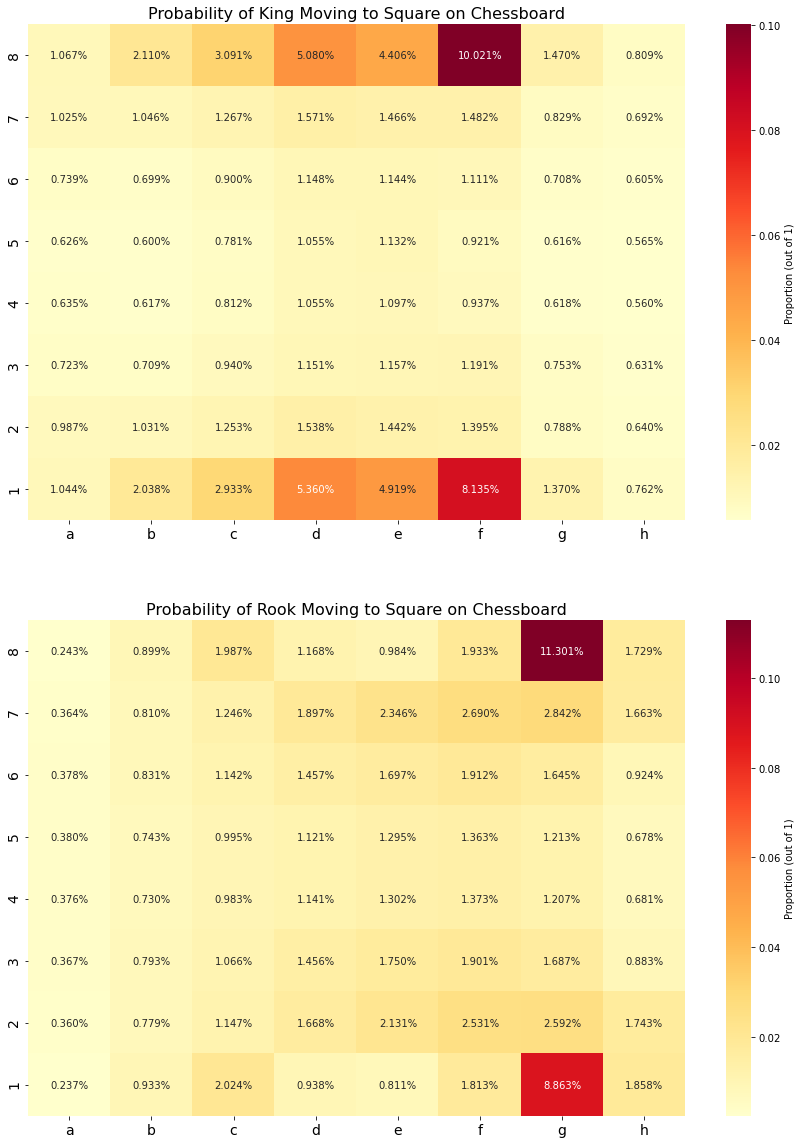

In [43]:
with multiprocessing.Pool(processes=splits) as pool:
    %time prob_castling_list = pool.map(partial(piece_prob, castling=True), input_games)
    
visualize_piece_prob(prob_castling_list, visualize_list_raw=['King', 'Rook'])

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Before that, just for reference, I've included an example of using the castling method here. Including castling heavily skews the data to kingside castling squares, so I don't include them in my later analysis. It's worth noting that many games will just end with the king ending on g1/g8 (after kingside castling) and the rook not moving from its square on f1/f8.</p>

In [44]:
def piece_color_prob(games, castling=False):
    prob_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    #chessboard representation in dict form, must recreate each dict b/c of how python dicts work
    colors = ['White', 'Black']
    
    for color in colors:
        prob_color_dict = {}
        for p in pieces:
            chess_dict = {}
            for horizontal in pawn:
                for vertical in range(1, 9):
                    chess_dict[horizontal+str(vertical)] = 0
            prob_color_dict[p] = chess_dict
        prob_dict[color] = prob_color_dict

    for game in games['PGN']:
        curr_move = False
        s = ""
        piece_id = ""
        white = True
        for index in range(len(game)):
            if game[index] == " " and curr_move:
                if piece_id == 'O':
                    white = 1-white
                    continue
                    
                curr_move = False
                if len(s) >= 4:
                    # Determine whether move is a promotion, e.g. e8=Q
                    s1 = s[0:2]
                    
                    # Some anomalies, like exd1=Q+ cannot be solve without manually going through the string and trying possibilities
                    try:
                        if white:
                            prob_dict['White'][piece_id][s1] += 0
                        else:
                            prob_dict['Black'][piece_id][s1] += 0
                    except:
                        s1 = s[1:3]
                elif len(s) == 3:
                    # Determine whether is a move that isn't just a piece to a square, e.g. Ngf6 (which is read as gf6) or exf6 (which is read as ef6)
                    s1 = s[len(s)-2:len(s)]
                else:
                    s1 = s
                
                # Ensure the string is made correctly
                try:
                    if white:
                        prob_dict['White'][piece_id][s1] += 1
                    else:
                        prob_dict['Black'][piece_id][s1] += 1
                except:
                    print(game)
                    raise Exception("There is an error in the code at this game.")
                
                # Reset string
                s = "" 
                white = 1-white
            elif curr_move:
                if game[index] != 'x' and game[index] != '+' and game[index] != '#' and game[index] != '!' and game[index] != '?':
                    # Captures, checks, checkmates, and other notation do not affect where a piece moves
                    s += game[index]
            elif game[index] in pawn:
                piece_id = 'P' 
                curr_move = True
                # If the move is a pawn, then the current character is actually part of its movement
                s += game[index]
            elif game[index] in pieces:
                piece_id = game[index]
                curr_move = True
            elif game[index] == 'O':
                curr_move = True
                piece_id = 'O'
                
                if castling:
                    try:
                        if game[index+1] == '-':
                            if game[index+3] == '-':
                                # Queenside castling
                                if game[index-2] == '.':
                                    prob_dict['White']['K']['c1'] += 1
                                    prob_dict['White']['R']['d1'] += 1
                                else:
                                    prob_dict['Black']['K']['c8'] += 1
                                    prob_dict['Black']['R']['d8'] += 1
                            else:
                                # Kingside castling
                                if game[index-2] == '.':
                                    prob_dict['Black']['K']['g1'] += 1
                                    prob_dict['Black']['R']['f1'] += 1
                                else:
                                    prob_dict['Black']['K']['g8'] += 1
                                    prob_dict['Black']['R']['f8'] += 1
                    except:
                        pass

    return prob_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time prob_color_list = pool.map(partial(piece_color_prob, castling=False), input_games)

CPU times: user 1.64 s, sys: 1.2 s, total: 2.84 s
Wall time: 1min 4s


In [45]:
def visualize_piece_color_prob(prob_color_list, colors=['White', 'Black'], visualize_list_raw=['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King'], 
                               side_by_side=False, vis_percentage=True):
    """
    Driver function for visualizing the probability that each chess piece lands on a certain square
    Utilizes seaborn heatmap, if set to false, will use matplotlib heatmap
    """
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    if side_by_side:
        fig, ax = plt.subplots(len(visualize_list_raw), len(colors), figsize=(12*len(colors), 8*len(visualize_list_raw)))
        
    l = 0
    for color in colors:
        P_dict = {}
        for p in pieces:
            chess_dict = {}
            for horizontal in pawn:
                for vertical in range(1, 9):
                    chess_dict[horizontal+str(vertical)] = 0
            P_dict[p] = chess_dict

        for prob_dict in prob_color_list:
            for piece in prob_dict[color]:
                for key in prob_dict[color][piece]:
                    P_dict[piece][key] += prob_dict[color][piece][key]

        visualize_list = []
        for label in visualize_list_raw:
            if label == 'Knight':
                visualize_list.append('N')
            else:
                visualize_list.append(label[0])
        
        if not side_by_side:
            fig, ax = plt.subplots(len(visualize_list), figsize=(12, len(visualize_list)*8))
            
        r = 0
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(val_list[i+8*j]/summ)
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)
            
            curr_ax = ax[r][l] if side_by_side else ax[r]
            heatmap = sns.heatmap(plot_list, cmap='YlOrRd', annot=True, fmt=".3%" if vis_percentage else "d", ax=curr_ax, 
                                  cbar_kws={'label': 'Proportion (out of 1)' if vis_percentage else 'Raw Count'})
            curr_ax.set_title("%s of %s Moving to Square on Chessboard, Only %s" % ('Probability' if vis_percentage else 'Raw Count', visualize_list_raw[r], color), fontsize=16)
            curr_ax.set_xticklabels(pawn, fontsize=14)
            curr_ax.set_yticklabels(np.arange(8, 0, -1), fontsize=14)
            r += 1
        l += 1
        
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()

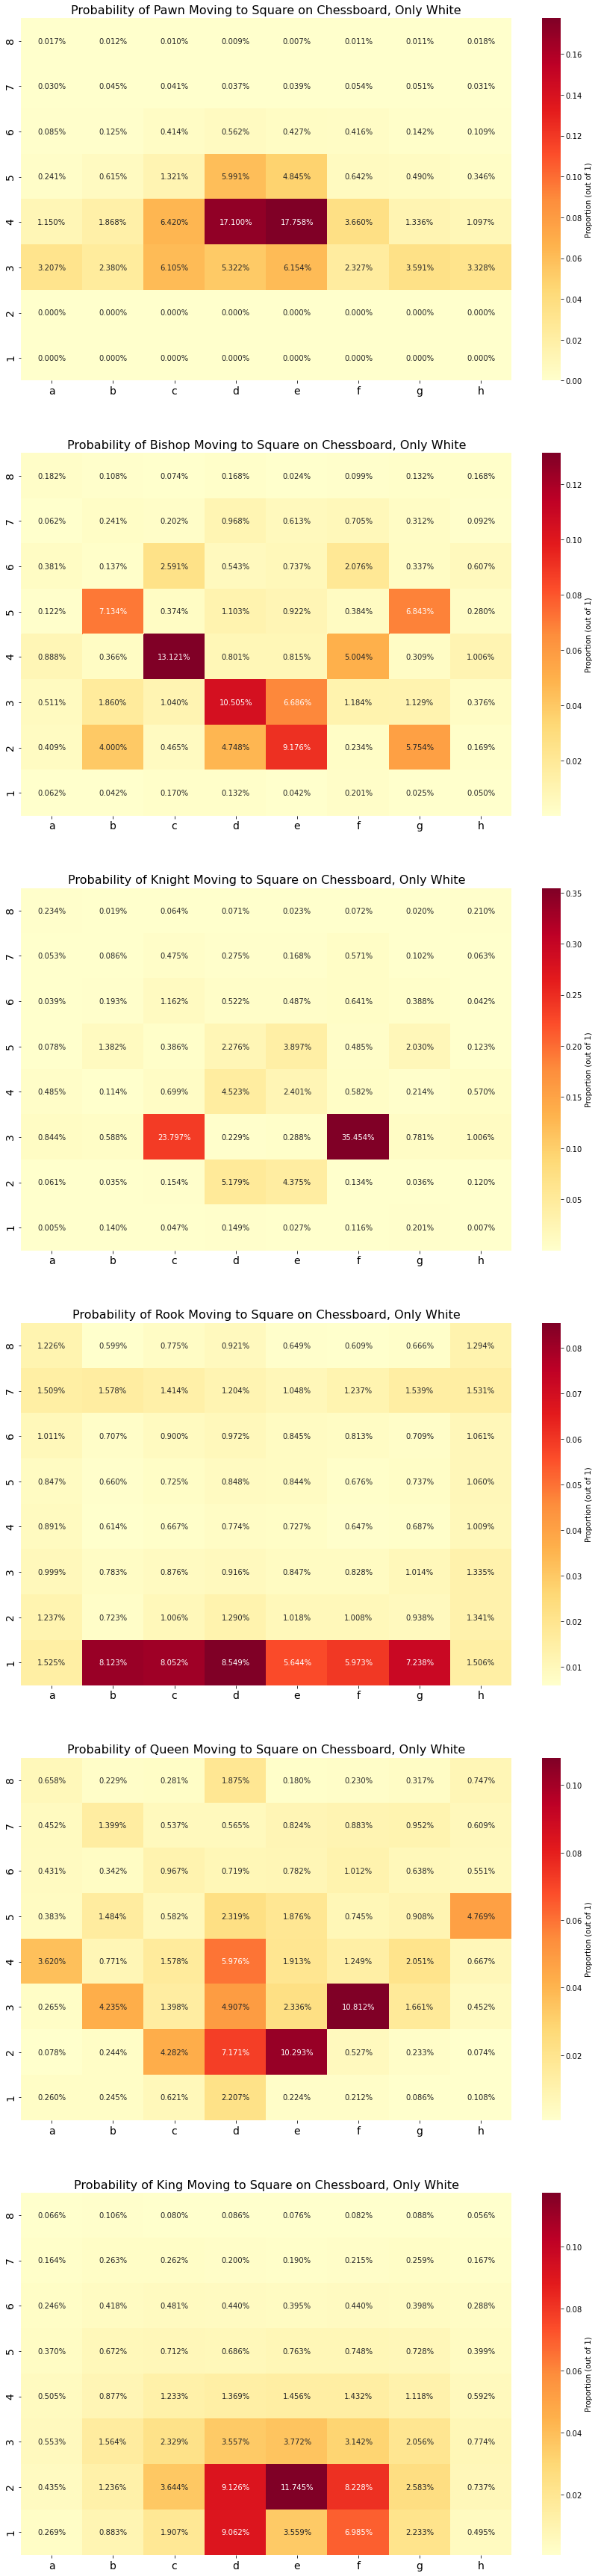

In [46]:
visualize_piece_color_prob(prob_color_list, colors=['White'])

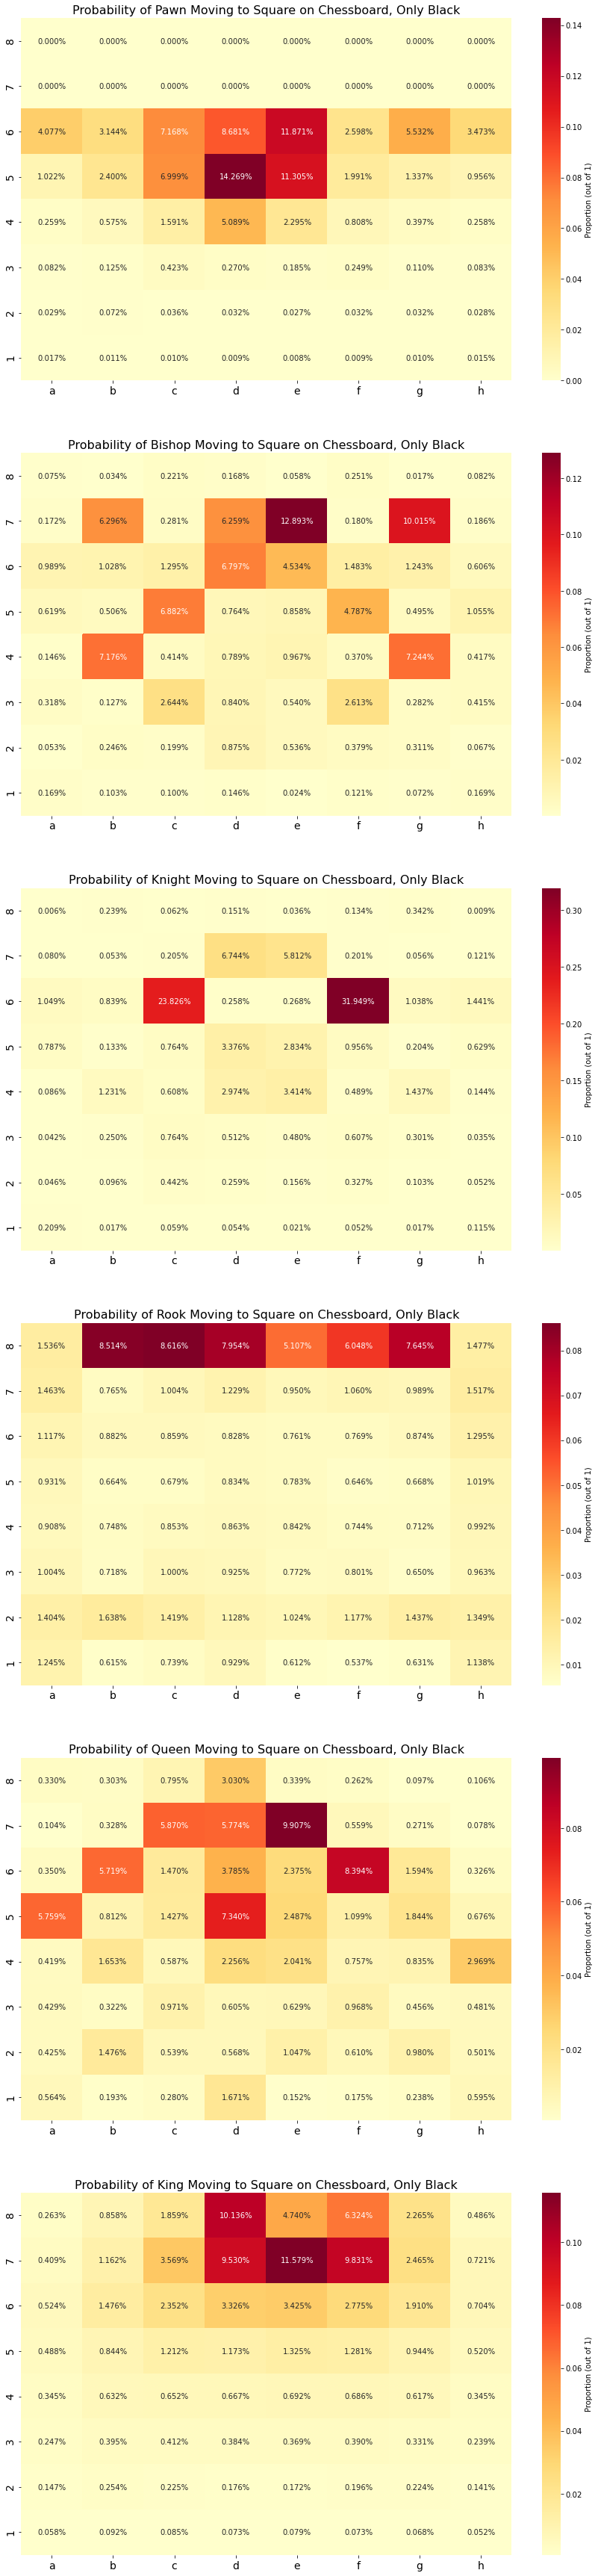

In [47]:
visualize_piece_color_prob(prob_color_list, colors=['Black'])

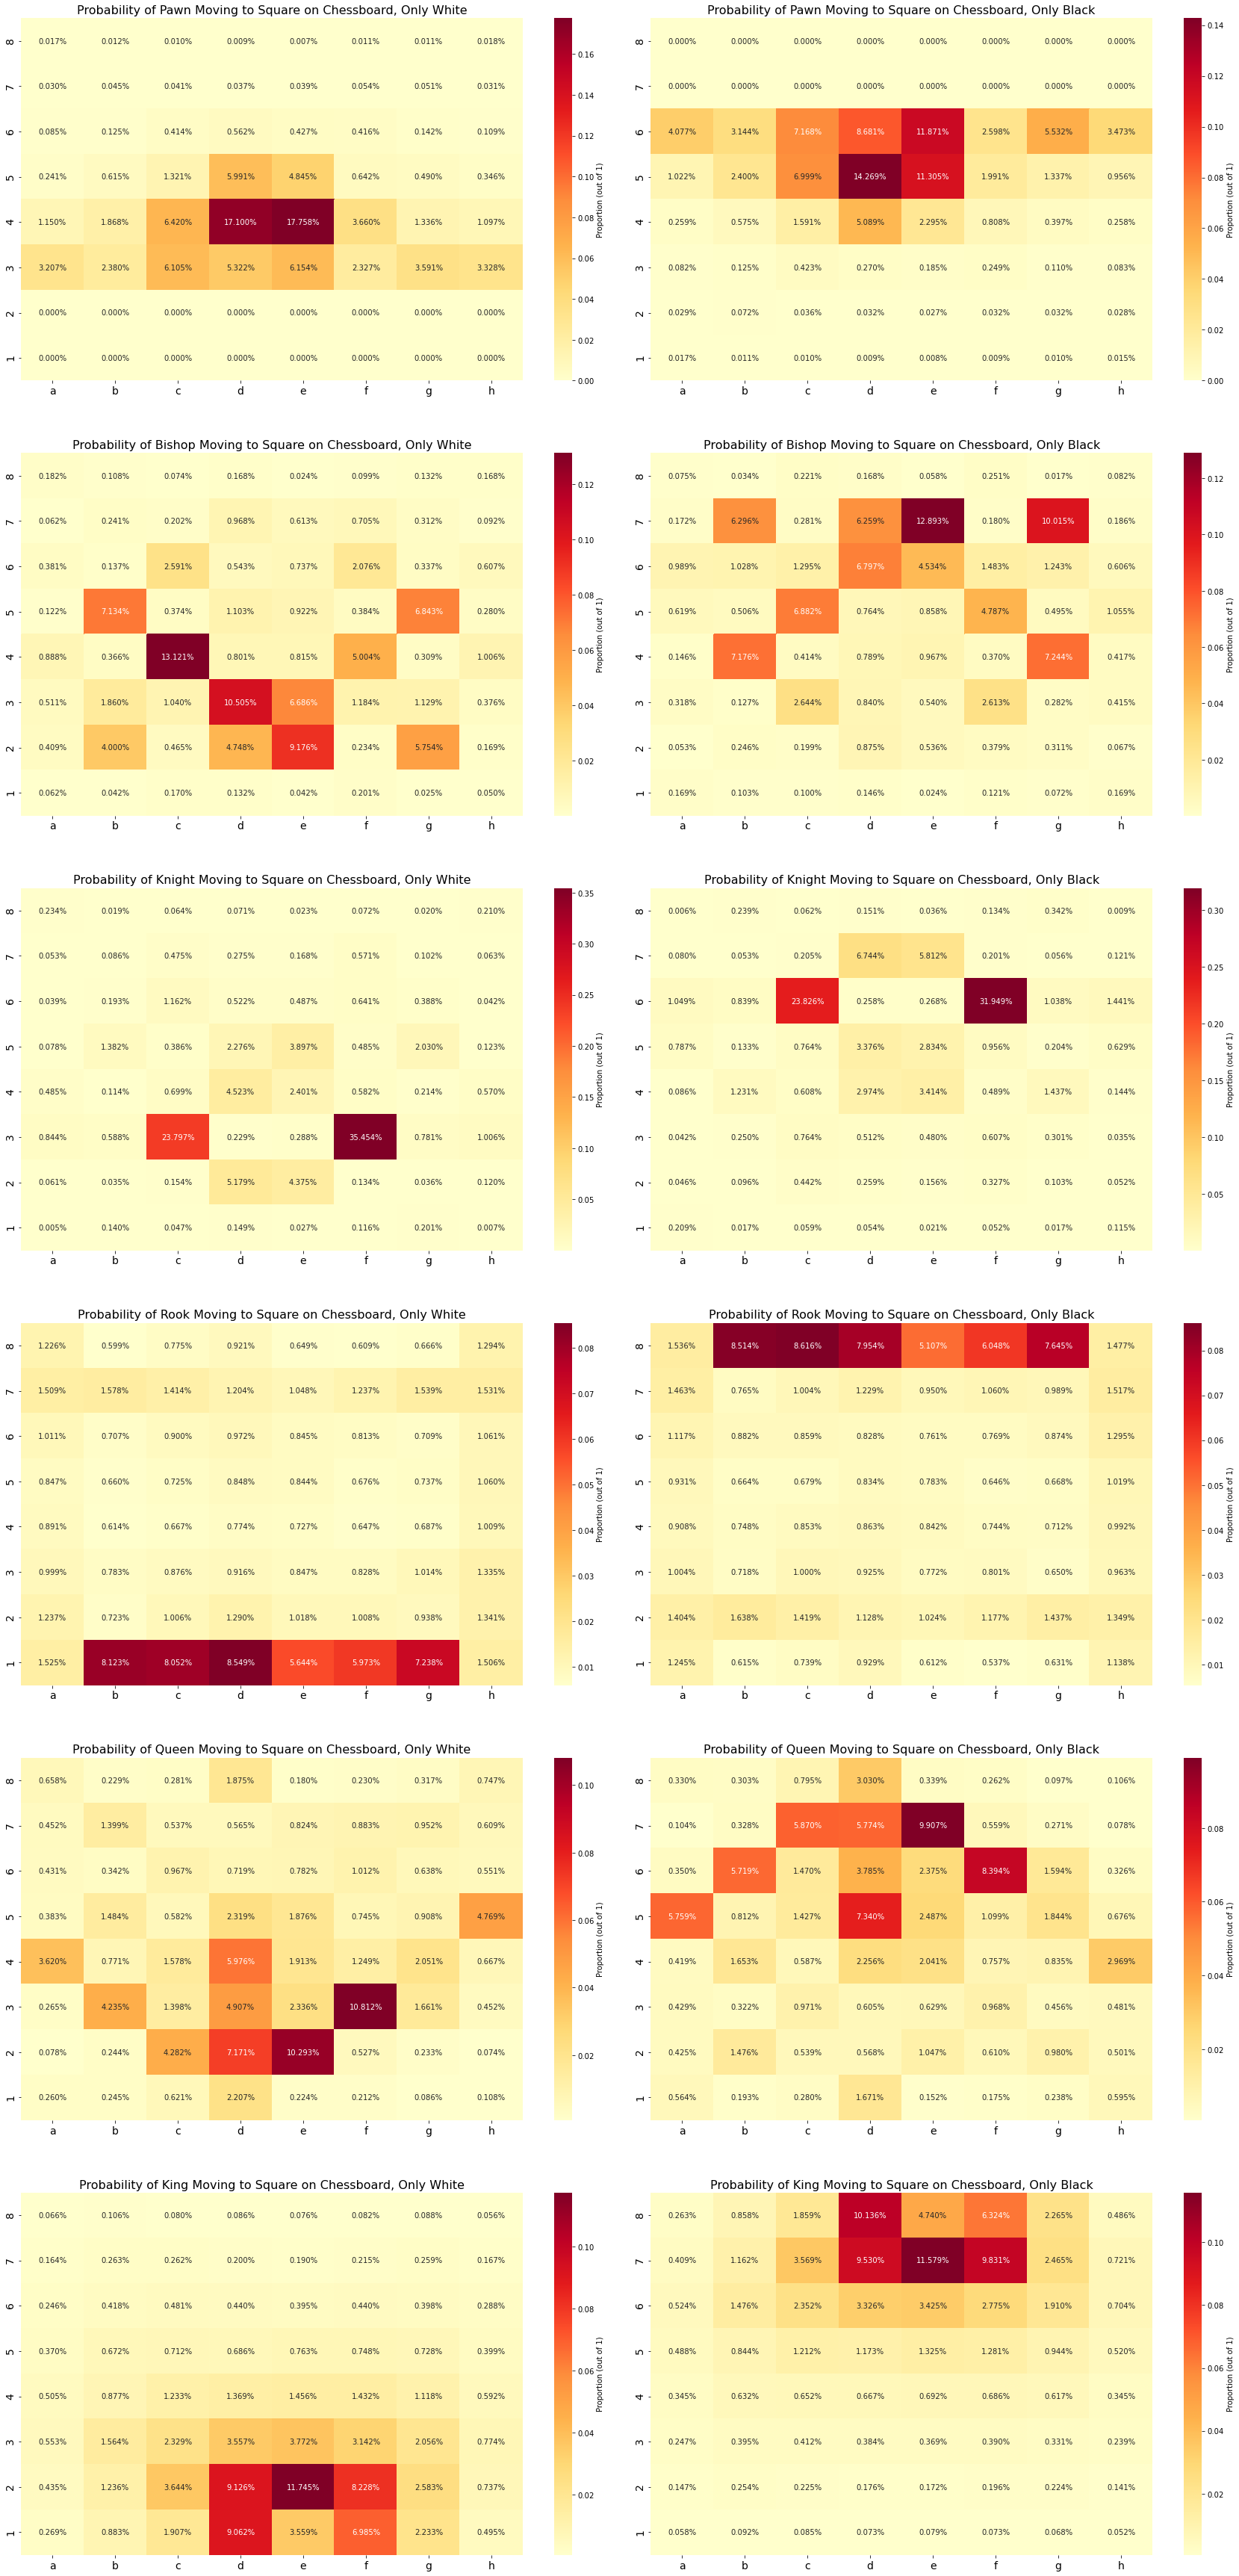

In [48]:
visualize_piece_color_prob(prob_color_list, side_by_side=True)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Splitting the colors up makes it alot easier to see the differences between the play of different colors, and here is where I do the bulk of my analysis: </p>
    
<ol style="font-size:15px; font-family:verdana; line-height: 1.7em">
    <ul> Pawn: Most players with the white pieces will move e4 at some point, whereas black plays its counterpart (e5) far less. An plausible explanation for such a trend is that in many openings like the Sicilian and Queen's Gambit Declined (QGD), the black e pawn will perch itself on e6. White, on the other hand, will typically expand their central control with pawn to e4, even in openings like the QGD (e.g., Grunfeld Defense). White also pushes their pawn to the 5th rank far more than black does, implying that white has an immediate <span style="font-weight: bold">space</span> advantage. </ul>
    <ul> Bishop: Bishop to c4 is extremely common for white, whereas its counterpart (Bishop to c5) by black is quite uncommon, with Bishop to e7 being the preferred choice for black. This may due to differences in <span style="font-weight: bold">development</span>; white wants to put their light-squared bishop in an attacking position, whereas black would like to first play solid and equalize before launching a counter-attack. Black also tends to <span style="font-weight: bold">fianchetto</span>—putting their bishop on b7/g7 to control the long diagonal—more often than white, supporting the counter-attacking nature of Black. Black also plays b6/g6 more often than white to fianchetto their bishop).</ul>
    <ul> Knight: Black plays its knight to the 7th rank more often than white, which can be explained by the fact white will oftentimes decide to push its d/e pawn to the 5th rank, gaining space and attacking the knight on the 6th rank, forcing it to retreat. For both sides though, knight moves to the c3/f3/c6/f6 are by far the most common (>50%).</ul>
    <ul> Rook: Surprisingly, rooks played on the queenside are more common than towards the center, with Rb8/Rc8 being played more often than Rd8/Re8 for black (and the counterpart squares for white are not far behind). </ul>
    <ul> Queen: Very similar distribution for the white and black player except Qc7 is played a bit more often than Qc2 (Qc7 in the Sicilian is very common). Qd5 and Qa5 are also very common moves for black, perhaps suggesting some type of Scandanavian setup being heavily played in this data.</ul>
    <ul> King: Pretty much the same. Most king moves are towards the center. </ul>
</ol>
    
<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Finally, I've included a visualization of different squares pieces move to for differently rated players.</p>

In [49]:
def piece_rating_prob(games, rating_range=[750, 1250, 1750, 2250], castling=False):
    prob_dict = {}
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

    #chessboard representation in dict form, must recreate each dict b/c of how python dicts work
    for rating in rating_range:
        rating_prob_dict = {}
        for p in pieces:
            chess_dict = {}
            for horizontal in pawn:
                for vertical in range(1, 9):
                    chess_dict[horizontal+str(vertical)] = 0
            rating_prob_dict[p] = chess_dict
        prob_dict[rating] = rating_prob_dict

    r = 0
    for game in games['PGN']:
        rating_type = -1
        for i in range(len(rating_range)):
            if i == 0:
                continue
            try:
                if games['Average Rating'][r] < rating_range[i]:
                    rating_type = rating_range[i-1]
                    break
            except:
                print(r)
                raise Exception("Error.")
        if rating_type == -1:
            rating_type = 2250
        curr_move = False
        s = ""
        piece_id = ""
        for index in range(len(game)):
            if game[index] == " " and curr_move:
                curr_move = False
                if len(s) >= 4:
                    # Determine whether move is a promotion, e.g. e8=Q
                    s1 = s[0:2]
                    
                    # Some anomalies, like exd1=Q+ cannot be solve without manually going through the string and trying possibilities
                    try:
                        prob_dict[1250][piece_id][s1] += 0
                    except:
                        s1 = s[1:3]
                elif len(s) == 3:
                    # Determine whether is a move that isn't just a piece to a square, e.g. Ngf6 (which is read as gf6) or exf6 (which is read as ef6)
                    s1 = s[len(s)-2:len(s)]
                else:
                    s1 = s
                
                # Ensure the string is made correctly
                try:
                    prob_dict[rating_type][piece_id][s1] += 1
                except:
                    print(game)
                    raise Exception("There is an error in the code at this game.")
                
                # Reset string
                s = "" 
            elif curr_move:
                if game[index] != 'x' and game[index] != '+' and game[index] != '#' and game[index] != '!' and game[index] != '?':
                    # Captures, checks, checkmates, and other notation do not affect where a piece moves
                    s += game[index]
            elif game[index] in pawn:
                piece_id = 'P' 
                curr_move = True
                # If the move is a pawn, then the current character is actually part of its movement
                s += game[index]
            elif game[index] in pieces:
                piece_id = game[index]
                curr_move = True
            elif game[index] == 'O' and castling:
                try:
                    if game[index+1] == '-':
                        if game[index+3] == '-':
                            # Queenside castling
                            if game[index-2] == '.':
                                prob_dict['K']['c1'] += 1
                                prob_dict['R']['d1'] += 1
                            else:
                                prob_dict['K']['c8'] += 1
                                prob_dict['R']['d8'] += 1
                        else:
                            # Kingside castling
                            if game[index-2] == '.':
                                prob_dict['K']['g1'] += 1
                                prob_dict['R']['f1'] += 1
                            else:
                                prob_dict['K']['g8'] += 1
                                prob_dict['R']['f8'] += 1
                except:
                    pass
        r += 1

    return prob_dict

with multiprocessing.Pool(processes=splits) as pool:
    %time prob_rating_list = pool.map(partial(piece_rating_prob, castling=False), input_games)

CPU times: user 1.68 s, sys: 1.22 s, total: 2.9 s
Wall time: 1min 26s


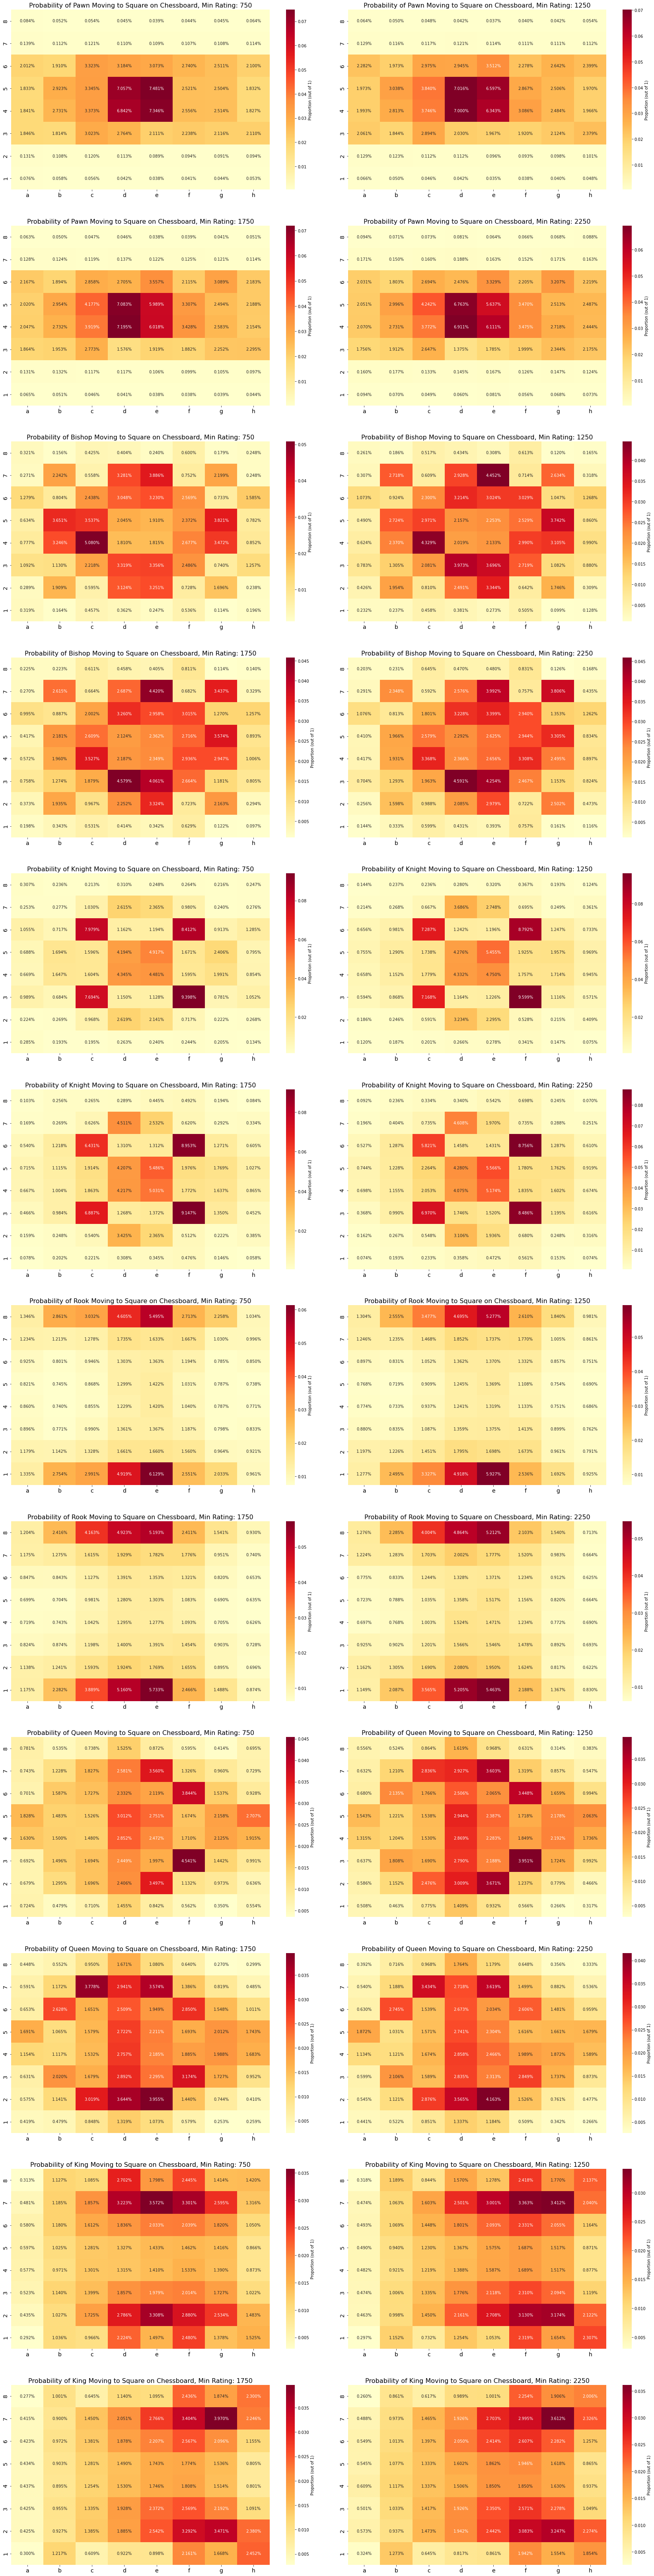

In [50]:
def visualize_piece_rating_prob(prob_rating_list, rating_range=[750, 1250, 1750, 2250], visualize_list_raw=['Pawn', 'Bishop', 'Knight', 'Rook', 'Queen', 'King'], vis_percentage=True):
    """
    Driver function for visualizing the probability that each chess piece lands on a certain square
    Utilizes seaborn heatmap, if set to false, will use matplotlib heatmap
    """
    pieces = ['P', 'B', 'N', 'R', 'Q', 'K']
    pawn = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    
    fig, ax = plt.subplots(len(visualize_list_raw)*2, int(len(rating_range)/2), figsize=(6*len(rating_range), 15*len(visualize_list_raw)))
    k = 0
    for rating in rating_range:
        P_dict = {}
        for p in pieces:
            chess_dict = {}
            for horizontal in pawn:
                for vertical in range(1, 9):
                    chess_dict[horizontal+str(vertical)] = 0
            P_dict[p] = chess_dict

        for prob_dict in prob_rating_list:
            for piece in prob_dict[rating]:
                for key in prob_dict[rating][piece]:
                    P_dict[piece][key] += prob_dict[rating][piece][key]

        visualize_list = []
        for label in visualize_list_raw:
            if label == 'Knight':
                visualize_list.append('N')
            else:
                visualize_list.append(label[0])

        r = 0
        for piece in P_dict:
            if piece not in visualize_list:
                continue

            val_list = list(P_dict[piece].values())
            summ = sum(val_list)
            plot_list = []
            for i in np.arange(7, -1, -1):
                tmp_list = []
                for j in range(8):
                    if vis_percentage:
                        tmp_list.append(val_list[i+8*j]/summ)
                    else:
                        tmp_list.append(val_list[i+8*j])
                plot_list.append(tmp_list)

            heatmap = sns.heatmap(plot_list, cmap='YlOrRd', annot=True, fmt=".3%" if vis_percentage else "d", ax=ax[r*2+int(k/2)][k%2], 
                                  cbar_kws={'label': 'Proportion (out of 1)' if vis_percentage else 'Raw Count'})
            ax[r*2+int(k/2)][k%2].set_title("%s of %s Moving to Square on Chessboard, Min Rating: %d" % ('Probability' if vis_percentage else 'Raw Count', visualize_list_raw[r], rating), fontsize=16)
            ax[r*2+int(k/2)][k%2].set_xticklabels(pawn, fontsize=14)
            ax[r*2+int(k/2)][k%2].set_yticklabels(np.arange(8, 0, -1), fontsize=14)
            r += 1
        
        k += 1
    fig.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()
        
visualize_piece_rating_prob(prob_rating_list)

<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> Once again, there's quite alot to digest, but I will leave the reader with some of my observations: Master players seem to fianchetto and play on the long diagonals a lot more than beginner players; f3 is a popular square for beginners to put their queen (probably after black plays Bg4, Bxf3) whereas e2 is a far more popular square for master players to put their queen; beginner players seem to move Ke2 very often, implying that many don't castle. Still, the central concept of chess is the same: <span style="font-weight: bold">Control the center!</span> </p>

<h1 class="alert alert-block alert-info" style="text-align:center; font-size:24px" id="conclusion"> Conclusion <a class="anchor-link" href="https://www.kaggle.com/ironicninja/visualizing-chess-game-length-and-piece-movement/notebook#conclusion">¶</a></h1>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em"> And that's all for this notebook! If you were a beginner and new/interested in chess, I hope you learned quite alot and will start/continue playing chess. It is a great game to study and play, so you will definitely not regret investing some time and effort into it. For intermediate/advanced/master players, I hope you enjoyed these visualizations and can maybe incorporate some of the concepts you see here into your own games. </p>
    
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">I am thinking about adding a Part 3, which will use a chess database with only master games, and thus be more educational and informative than this one. If you liked the visualizations here, please give it an <span style="color: green; font-weight: bold">upvote!</span> This project has taken me quite a long time and I would really appreciate it. Finally, if you have any comments of encouragement or improvement, or suggestions for other tasks I can do with this data, please let me know!</p>